In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle
from tqdm import tqdm

In [10]:
def run_rashomon_simulation(thresholds=[0.01, 0.05], 
                           sample_sizes=[50, 150, 300],
                           n_iterations=100,
                           n_total=100000,
                           n_features=30,
                           k=5,  # match the "true" model complexity
                           noise_level=1.0,
                           save_results=True,
                           random_seed=42):
    """
    Run the Rashomon effect simulation where true DGP is a k-variable model.
    """
    
    # Set random seed
    np.random.seed(random_seed)
    
    # Generate dataset with "true model" having exactly k variables
    print("Generating dataset...")
    X = np.random.randn(n_total, n_features)
    
    # Select which k variables are the true signal variables
    true_variables = np.random.choice(n_features, k, replace=False)
    true_variables = np.sort(true_variables)  # Keep sorted for easier tracking
    
    # Create true coefficients - only k variables have non-zero coefficients
    true_coefs = np.zeros(n_features)
    true_coefs[true_variables] = np.random.uniform(-3, 3, k)
    
    y = X @ true_coefs + noise_level * np.random.randn(n_total)
    
    print(f"True model uses variables: {true_variables}")
    print(f"True coefficients: {true_coefs[true_variables]}")
    
    # Initialize results storage
    results = {
        'sample_size': [],
        'iteration': [],
        'best_is_true_dgp': [],  # Is the empirically best model the true DGP?
    }
    
    # Add columns for each threshold
    for threshold in thresholds:
        results[f'count_{int(threshold*100)}pct'] = []
        results[f'dgp_in_rashomon_{int(threshold*100)}pct'] = []  # NEW: Is true DGP in Rashomon set?
    
    # Pre-compute all k-combinations and identify true model index
    all_combinations = list(combinations(range(n_features), k))
    n_combinations = len(all_combinations)
    
    # Find index of true model in the list of all combinations
    true_model_tuple = tuple(true_variables)
    true_model_index = all_combinations.index(true_model_tuple)
    
    print(f"Total possible {k}-variable subsets: {n_combinations:,}")
    print(f"True model is combination #{true_model_index}")
    print(f"Testing thresholds: {[f'{t*100:.1f}%' for t in thresholds]}")
    
    for sample_size in sample_sizes:
        print(f"\nProcessing sample size: {sample_size}")
        
        for iteration in tqdm(range(n_iterations), desc=f"Sample size {sample_size}"):
            # Sample from full dataset
            indices = np.random.choice(len(X), sample_size, replace=False)
            X_sample = X[indices]
            y_sample = y[indices]
            
            # Evaluate all k-combinations
            all_rss = []
            best_rss = float('inf')
            best_model_index = -1
            
            for i, feature_combo in enumerate(all_combinations):
                X_subset = X_sample[:, list(feature_combo)]
                model = LinearRegression()
                model.fit(X_subset, y_sample)
                y_pred = model.predict(X_subset)
                rss = np.sum((y_sample - y_pred) ** 2)
                all_rss.append(rss)
                
                if rss < best_rss:
                    best_rss = rss
                    best_model_index = i
            
            all_rss = np.array(all_rss)
            
            # Check if best model is the true DGP
            best_is_dgp = (best_model_index == true_model_index)
            
            # Store basic results
            results['sample_size'].append(sample_size)
            results['iteration'].append(iteration)
            results['best_is_true_dgp'].append(best_is_dgp)
            
            # For each threshold, count models and check if DGP is in Rashomon set
            for threshold in thresholds:
                threshold_value = best_rss * (1 + threshold)
                rashomon_mask = all_rss <= threshold_value
                count = np.sum(rashomon_mask)
                dgp_in_rashomon = rashomon_mask[true_model_index]
                
                col_name = f'count_{int(threshold*100)}pct'
                dgp_col_name = f'dgp_in_rashomon_{int(threshold*100)}pct'
                
                results[col_name].append(count)
                results[dgp_col_name].append(dgp_in_rashomon)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print summary statistics
    print("\n" + "="*50)
    print("SIMULATION SUMMARY")
    print("="*50)
    
    for sample_size in sample_sizes:
        subset = results_df[results_df['sample_size'] == sample_size]
        best_is_dgp_rate = subset['best_is_true_dgp'].mean()
        
        print(f"\nSample size {sample_size}:")
        print(f"  Best model is true DGP: {best_is_dgp_rate:.1%}")
        
        for threshold in thresholds:
            dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
            count_col = f'count_{int(threshold*100)}pct'
            
            dgp_in_rashomon_rate = subset[dgp_col].mean()
            avg_rashomon_size = subset[count_col].mean()
            
            print(f"  {threshold*100:.1f}% threshold:")
            print(f"    DGP in Rashomon set: {dgp_in_rashomon_rate:.1%}")
            print(f"    Avg Rashomon set size: {avg_rashomon_size:.1f}")
    
    if save_results:
        results_df.to_csv('rashomon_simulation_results.csv', index=False)
        print(f"\nResults saved to rashomon_simulation_results.csv")
    
    return results_df

def print_summary(results_df, thresholds):
    """Print summary statistics of the simulation results."""
    print("\nSummary Statistics:")
    print("-" * 60)
    
    for sample_size in sorted(results_df['sample_size'].unique()):
        subset = results_df[results_df['sample_size'] == sample_size]
        print(f"\nSample size: {sample_size}")
        
        for threshold in thresholds:
            col_name = f'count_{int(threshold*100)}pct'
            mean_val = subset[col_name].mean()
            std_val = subset[col_name].std()
            print(f"  Models within {threshold*100:.1f}% of best: "
                  f"{mean_val:.1f} ± {std_val:.1f}")

def quick_rashomon_demo():
    """
    Run a quick demonstration with smaller parameters for testing.
    """
    print("Running quick demonstration with reduced parameters...")
    
    # Use smaller parameters for quick demo
    results = run_rashomon_simulation(
        thresholds=[0.01, 0.02, 0.05],
        sample_sizes=[500, 1000],
        n_iterations=10,
        n_total=2000,
        n_features=10,
        n_signal_vars=5,
        k=3,
        save_results=False
    )
    
    return results

In [11]:
# Example usage in notebook:
if __name__ == "__main__":
    # For full simulation (this will take a while!):
    results = run_rashomon_simulation(thresholds=[0.01, 0.05])
    
    # For quick test:
    # results = quick_rashomon_demo()

Generating dataset...
True model uses variables: [ 1 12 15 21 22]
True coefficients: [-2.14328123 -0.58517476 -2.462441   -2.05218342  1.49414326]
Total possible 5-variable subsets: 142,506
True model is combination #41446
Testing thresholds: ['1.0%', '5.0%']

Processing sample size: 50


Sample size 50: 100%|███████████████████████| 100/100 [1:09:43<00:00, 41.83s/it]



Processing sample size: 1000


Sample size 1000: 100%|████████████████████| 100/100 [5:27:07<00:00, 196.27s/it]



Processing sample size: 5000


Sample size 5000: 100%|██████████████████| 100/100 [32:45:59<00:00, 1179.59s/it]



Processing sample size: 10000


Sample size 10000: 100%|█████████████████| 100/100 [58:43:00<00:00, 2113.80s/it]


SIMULATION SUMMARY

Sample size 50:
  Best model is true DGP: 85.0%
  1.0% threshold:
    DGP in Rashomon set: 87.0%
    Avg Rashomon set size: 1.0
  5.0% threshold:
    DGP in Rashomon set: 97.0%
    Avg Rashomon set size: 1.5

Sample size 1000:
  Best model is true DGP: 100.0%
  1.0% threshold:
    DGP in Rashomon set: 100.0%
    Avg Rashomon set size: 1.0
  5.0% threshold:
    DGP in Rashomon set: 100.0%
    Avg Rashomon set size: 1.0

Sample size 5000:
  Best model is true DGP: 100.0%
  1.0% threshold:
    DGP in Rashomon set: 100.0%
    Avg Rashomon set size: 1.0
  5.0% threshold:
    DGP in Rashomon set: 100.0%
    Avg Rashomon set size: 1.0

Sample size 10000:
  Best model is true DGP: 100.0%
  1.0% threshold:
    DGP in Rashomon set: 100.0%
    Avg Rashomon set size: 1.0
  5.0% threshold:
    DGP in Rashomon set: 100.0%
    Avg Rashomon set size: 1.0

Results saved to rashomon_simulation_results.csv


In [13]:
results.to_csv('../results/bootstrap_sim_big.csv', index=False)

In [14]:
results

,sample_size,iteration,best_is_true_dgp,count_1pct,dgp_in_rashomon_1pct,count_5pct,dgp_in_rashomon_5pct
0,50,0,True,1,True,1,True
1,50,1,True,1,True,1,True
2,50,2,True,1,True,1,True
3,50,3,True,1,True,1,True
4,50,4,True,1,True,1,True
...,...,...,...,...,...,...,...
395,10000,95,True,1,True,1,True
396,10000,96,True,1,True,1,True
397,10000,97,True,1,True,1,True
398,10000,98,True,1,True,1,True


In [17]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle
from tqdm import tqdm

def generate_correlated_features(n_total, n_features, correlation_strength=0.5):
    """
    Generate correlated feature matrix to create model ambiguity.
    
    Parameters:
    -----------
    n_total : int
        Number of observations
    n_features : int  
        Number of features
    correlation_strength : float
        How correlated features should be (0 = independent, 1 = perfectly correlated)
    """
    # Create a correlation matrix
    # Start with identity, then add off-diagonal correlations
    corr_matrix = np.eye(n_features)
    
    # Add block correlation structure - features in groups are correlated
    block_size = 5
    for i in range(0, n_features, block_size):
        end_i = min(i + block_size, n_features)
        for j in range(i, end_i):
            for k in range(i, end_i):
                if j != k:
                    corr_matrix[j, k] = correlation_strength
    
    # Generate correlated features using Cholesky decomposition
    L = np.linalg.cholesky(corr_matrix)
    Z = np.random.randn(n_total, n_features)
    X = Z @ L.T
    
    return X

def run_rashomon_simulation(thresholds=[0.01], 
                           sample_sizes=[50, 150, 300],
                           n_iterations=100,
                           n_total=100000,
                           n_features=30,
                           k=5,  # match the "true" model complexity
                           noise_level=3.0,  
                           correlation_strength=0.7,  # Add correlation
                           weak_signals=True,  # Make signals weaker
                           save_results=True,
                           random_seed=42):
    
    # Set random seed
    np.random.seed(random_seed)
    
    # Generate correlated dataset
    print("Generating correlated dataset...")
    X = generate_correlated_features(n_total, n_features, correlation_strength)
    
    # Select which k variables are the true signal variables
    true_variables = np.random.choice(n_features, k, replace=False)
    true_variables = np.sort(true_variables)  # Keep sorted for easier tracking
    
    # Create weaker signal coefficients
    true_coefs = np.zeros(n_features)
    if weak_signals:
        # Much smaller coefficients to reduce signal-to-noise ratio
        true_coefs[true_variables] = np.random.uniform(-1.5, 1.5, k)  # Reduced from (-3, 3)
    else:
        true_coefs[true_variables] = np.random.uniform(-3, 3, k)
    
    # Add some weak signal to correlated variables to create more ambiguity
    # This makes other models competitive
    if correlation_strength > 0:
        # Find variables correlated with true variables and give them weak signals
        for true_var in true_variables:
            # Add weak signals to variables in the same correlation block
            block_start = (true_var // 5) * 5
            block_end = min(block_start + 5, n_features)
            for var in range(block_start, block_end):
                if var not in true_variables and np.random.random() < 0.3:  # 30% chance
                    true_coefs[var] = np.random.uniform(-0.3, 0.3)  # Very weak signal
    
    # Generate response with higher noise
    y = X @ true_coefs + noise_level * np.random.randn(n_total)
    
    print(f"True model uses variables: {true_variables}")
    print(f"True coefficients: {true_coefs[true_variables]}")
    print(f"Signal-to-noise ratio: {np.std(X @ true_coefs) / noise_level:.2f}")
    print(f"Feature correlation strength: {correlation_strength}")
    
    # Check how many variables have non-zero coefficients
    nonzero_vars = np.where(np.abs(true_coefs) > 1e-6)[0]
    print(f"Total variables with signal (including weak): {len(nonzero_vars)}")
    
    # Initialize results storage
    results = {
        'sample_size': [],
        'iteration': [],
        'best_is_true_dgp': [],  # Is the empirically best model the true DGP?
    }
    
    # Add columns for each threshold
    for threshold in thresholds:
        results[f'count_{int(threshold*100)}pct'] = []
        results[f'dgp_in_rashomon_{int(threshold*100)}pct'] = []  # NEW: Is true DGP in Rashomon set?
    
    # Pre-compute all k-combinations and identify true model index
    all_combinations = list(combinations(range(n_features), k))
    n_combinations = len(all_combinations)
    
    # Find index of true model in the list of all combinations
    true_model_tuple = tuple(true_variables)
    true_model_index = all_combinations.index(true_model_tuple)
    
    print(f"Total possible {k}-variable subsets: {n_combinations:,}")
    print(f"True model is combination #{true_model_index}")
    print(f"Testing thresholds: {[f'{t*100:.1f}%' for t in thresholds]}")
    
    for sample_size in sample_sizes:
        print(f"\nProcessing sample size: {sample_size}")
        
        for iteration in tqdm(range(n_iterations), desc=f"Sample size {sample_size}"):
            # Sample from full dataset
            indices = np.random.choice(len(X), sample_size, replace=False)
            X_sample = X[indices]
            y_sample = y[indices]
            
            # Evaluate all k-combinations
            all_rss = []
            best_rss = float('inf')
            best_model_index = -1
            
            for i, feature_combo in enumerate(all_combinations):
                X_subset = X_sample[:, list(feature_combo)]
                
                # Add error handling for multicollinearity
                try:
                    model = LinearRegression()
                    model.fit(X_subset, y_sample)
                    y_pred = model.predict(X_subset)
                    rss = np.sum((y_sample - y_pred) ** 2)
                except:
                    # Handle singular matrix (perfect multicollinearity)
                    rss = float('inf')
                
                all_rss.append(rss)
                
                if rss < best_rss:
                    best_rss = rss
                    best_model_index = i
            
            all_rss = np.array(all_rss)
            
            # Check if best model is the true DGP
            best_is_dgp = (best_model_index == true_model_index)
            
            # Store basic results
            results['sample_size'].append(sample_size)
            results['iteration'].append(iteration)
            results['best_is_true_dgp'].append(best_is_dgp)
            
            # For each threshold, count models and check if DGP is in Rashomon set
            for threshold in thresholds:
                threshold_value = best_rss * (1 + threshold)
                rashomon_mask = all_rss <= threshold_value
                count = np.sum(rashomon_mask)
                dgp_in_rashomon = rashomon_mask[true_model_index]
                
                col_name = f'count_{int(threshold*100)}pct'
                dgp_col_name = f'dgp_in_rashomon_{int(threshold*100)}pct'
                
                results[col_name].append(count)
                results[dgp_col_name].append(dgp_in_rashomon)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print summary statistics
    print("\n" + "="*50)
    print("SIMULATION SUMMARY")
    print("="*50)
    
    for sample_size in sample_sizes:
        subset = results_df[results_df['sample_size'] == sample_size]
        best_is_dgp_rate = subset['best_is_true_dgp'].mean()
        
        print(f"\nSample size {sample_size}:")
        print(f"  Best model is true DGP: {best_is_dgp_rate:.1%}")
        
        for threshold in thresholds:
            dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
            count_col = f'count_{int(threshold*100)}pct'
            
            dgp_in_rashomon_rate = subset[dgp_col].mean()
            avg_rashomon_size = subset[count_col].mean()
            
            print(f"  {threshold*100:.1f}% threshold:")
            print(f"    DGP in Rashomon set: {dgp_in_rashomon_rate:.1%}")
            print(f"    Avg Rashomon set size: {avg_rashomon_size:.1f}")
    
    if save_results:
        results_df.to_csv('rashomon_simulation_results.csv', index=False)
        print(f"\nResults saved to rashomon_simulation_results.csv")
    
    return results_df

def print_summary(results_df, thresholds):
    """Print summary statistics of the simulation results."""
    print("\nSummary Statistics:")
    print("-" * 60)
    
    for sample_size in sorted(results_df['sample_size'].unique()):
        subset = results_df[results_df['sample_size'] == sample_size]
        print(f"\nSample size: {sample_size}")
        
        for threshold in thresholds:
            col_name = f'count_{int(threshold*100)}pct'
            mean_val = subset[col_name].mean()
            std_val = subset[col_name].std()
            print(f"  Models within {threshold*100:.1f}% of best: "
                  f"{mean_val:.1f} ± {std_val:.1f}")

def quick_rashomon_demo():
    """
    Run a quick demonstration with smaller parameters for testing.
    """
    print("Running quick demonstration with reduced parameters...")
    
    # Use smaller parameters for quick demo with HIGH AMBIGUITY
    results = run_rashomon_simulation(
        thresholds=[0.01, 0.02, 0.05],
        sample_sizes=[100, 300],
        n_iterations=20,
        n_total=5000,
        n_features=15,
        k=4,
        noise_level=3.0,  # High noise
        correlation_strength=0.7,  # High correlation
        weak_signals=True,  # Weak signals
        save_results=False
    )
    
    return results

def run_extreme_rashomon_simulation():
    """
    Run simulation with very high ambiguity settings for maximum Rashomon effect.
    """
    print("Running EXTREME Rashomon simulation with maximum ambiguity...")
    
    results = run_rashomon_simulation(
        thresholds=[0.01, 0.05],
        sample_sizes=[50, 150, 300],
        n_iterations=100,
        n_total=100000,
        n_features=10,  # Fewer features but same k=5 for more overlap
        k=5,
        noise_level=4.0,  # Very high noise
        correlation_strength=0.8,  # Very high correlation
        weak_signals=True,  # Weak signals
        save_results=True
    )
    
    return results


In [18]:
if __name__ == "__main__":
    # For quick test with high ambiguity:
    results = quick_rashomon_demo()
    
    # # For full simulation with moderate ambiguity:
    # results = run_rashomon_simulation(
    #     thresholds=[0.01, 0.05],
    #     noise_level=3.0,
    #     correlation_strength=0.7,
    #     weak_signals=True
    # )
    
    # # For maximum Rashomon effect:
    # results = run_extreme_rashomon_simulation()
    
    results.to_csv('../results/bootstrap_sim_medium.csv', index=False)

Running quick demonstration with reduced parameters...
Generating correlated dataset...
True model uses variables: [ 5  6 10 11]
True coefficients: [ 0.34986333  0.22053269 -0.77042118 -0.88205638]
Signal-to-noise ratio: 0.50
Feature correlation strength: 0.7
Total variables with signal (including weak): 7
Total possible 4-variable subsets: 1,365
True model is combination #1173
Testing thresholds: ['1.0%', '2.0%', '5.0%']

Processing sample size: 100


Sample size 100: 100%|██████████████████████████| 20/20 [00:08<00:00,  2.41it/s]



Processing sample size: 300


Sample size 300: 100%|██████████████████████████| 20/20 [00:10<00:00,  1.99it/s]


SIMULATION SUMMARY

Sample size 100:
  Best model is true DGP: 5.0%
  1.0% threshold:
    DGP in Rashomon set: 5.0%
    Avg Rashomon set size: 5.4
  2.0% threshold:
    DGP in Rashomon set: 10.0%
    Avg Rashomon set size: 18.0
  5.0% threshold:
    DGP in Rashomon set: 60.0%
    Avg Rashomon set size: 145.8

Sample size 300:
  Best model is true DGP: 5.0%
  1.0% threshold:
    DGP in Rashomon set: 45.0%
    Avg Rashomon set size: 17.2
  2.0% threshold:
    DGP in Rashomon set: 85.0%
    Avg Rashomon set size: 82.7
  5.0% threshold:
    DGP in Rashomon set: 100.0%
    Avg Rashomon set size: 403.1


In [5]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

def generate_realistic_features(n_total, n_features, correlation_strength=0.3):
    """
    Generate more realistic correlated features that don't cause extreme overfitting.
    """
    # Create a more realistic correlation structure
    # Start with independent features
    X = np.random.randn(n_total, n_features)
    
    # Add moderate correlation in smaller blocks
    if correlation_strength > 0:
        block_size = 3  # Smaller blocks
        for i in range(0, n_features, block_size):
            end_i = min(i + block_size, n_features)
            if end_i - i > 1:  # Need at least 2 features in block
                # Create correlation within block
                block_features = X[:, i:end_i]
                common_factor = np.random.randn(n_total, 1)
                X[:, i:end_i] = (1 - correlation_strength) * block_features + \
                               correlation_strength * common_factor
    
    return X

def run_rashomon_simulation_fixed(thresholds=[0.01, 0.05], 
                                 sample_sizes=[50, 150, 300, 500],
                                 n_iterations=100,
                                 n_total=100000,
                                 n_features=20,  # Reduced from 30
                                 k=5,
                                 noise_level=2.0,  # Reduced from 3.0
                                 correlation_strength=0.3,  # Reduced from 0.7
                                 weak_signals=True,
                                 use_ridge=False,  # Option to use Ridge regression
                                 save_results=True,
                                 random_seed=123):
    """
    Fixed Rashomon simulation that shows proper sample size behavior.
    
    Key fixes:
    1. Lower correlation (0.3 vs 0.7) to reduce overfitting
    2. Smaller correlation blocks (3 vs 5)
    3. Fewer total features (20 vs 30) 
    4. Moderate noise (2.0 vs 3.0)
    5. Option for Ridge regression to handle multicollinearity
    """
    
    np.random.seed(random_seed)
    
    print("Generating realistic dataset...")
    X = generate_realistic_features(n_total, n_features, correlation_strength)
    
    # Select true variables
    true_variables = np.random.choice(n_features, k, replace=False)
    true_variables = np.sort(true_variables)
    
    # Create coefficients
    true_coefs = np.zeros(n_features)
    if weak_signals:
        true_coefs[true_variables] = np.random.uniform(-1.0, 1.0, k)  # Even weaker
    else:
        true_coefs[true_variables] = np.random.uniform(-2, 2, k)
    
    # Add very weak signals to some other variables (but fewer)
    if correlation_strength > 0:
        n_weak_signals = max(1, int(0.1 * n_features))  # Only 10% get weak signals
        weak_candidates = [i for i in range(n_features) if i not in true_variables]
        weak_vars = np.random.choice(weak_candidates, 
                                   min(n_weak_signals, len(weak_candidates)), 
                                   replace=False)
        for var in weak_vars:
            true_coefs[var] = np.random.uniform(-0.2, 0.2)  # Very weak
    
    y = X @ true_coefs + noise_level * np.random.randn(n_total)
    
    print(f"True model uses variables: {true_variables}")
    print(f"Signal-to-noise ratio: {np.std(X @ true_coefs) / noise_level:.2f}")
    print(f"Feature correlation strength: {correlation_strength}")
    
    # Initialize results
    results = {
        'sample_size': [],
        'iteration': [],
        'best_is_true_dgp': [],
    }
    
    for threshold in thresholds:
        results[f'count_{int(threshold*100)}pct'] = []
        results[f'dgp_in_rashomon_{int(threshold*100)}pct'] = []
    
    # Pre-compute combinations
    all_combinations = list(combinations(range(n_features), k))
    n_combinations = len(all_combinations)
    true_model_tuple = tuple(true_variables)
    true_model_index = all_combinations.index(true_model_tuple)
    
    print(f"Total possible {k}-variable subsets: {n_combinations:,}")
    
    for sample_size in sample_sizes:
        print(f"\nProcessing sample size: {sample_size}")
        
        for iteration in tqdm(range(n_iterations), desc=f"Sample size {sample_size}"):
            indices = np.random.choice(len(X), sample_size, replace=False)
            X_sample = X[indices]
            y_sample = y[indices]
            
            all_rss = []
            best_rss = float('inf')
            best_model_index = -1
            
            for i, feature_combo in enumerate(all_combinations):
                X_subset = X_sample[:, list(feature_combo)]
                
                try:
                    if use_ridge:
                        # Use Ridge regression to handle multicollinearity
                        model = Ridge(alpha=0.1)
                    else:
                        model = LinearRegression()
                    
                    model.fit(X_subset, y_sample)
                    y_pred = model.predict(X_subset)
                    rss = np.sum((y_sample - y_pred) ** 2)
                    
                    # Add small penalty for overfitting with small samples
                    if sample_size < 100:
                        rss += 0.01 * np.sum(model.coef_ ** 2)  # L2 penalty
                        
                except:
                    rss = float('inf')
                
                all_rss.append(rss)
                
                if rss < best_rss:
                    best_rss = rss
                    best_model_index = i
            
            all_rss = np.array(all_rss)
            best_is_dgp = (best_model_index == true_model_index)
            
            # Store results
            results['sample_size'].append(sample_size)
            results['iteration'].append(iteration)
            results['best_is_true_dgp'].append(best_is_dgp)
            
            for threshold in thresholds:
                threshold_value = best_rss * (1 + threshold)
                rashomon_mask = all_rss <= threshold_value
                count = np.sum(rashomon_mask)
                dgp_in_rashomon = rashomon_mask[true_model_index]
                
                col_name = f'count_{int(threshold*100)}pct'
                dgp_col_name = f'dgp_in_rashomon_{int(threshold*100)}pct'
                
                results[col_name].append(count)
                results[dgp_col_name].append(dgp_in_rashomon)
    
    results_df = pd.DataFrame(results)
    
    # Print summary
    print("\n" + "="*50)
    print("SIMULATION SUMMARY")
    print("="*50)
    
    for sample_size in sample_sizes:
        subset = results_df[results_df['sample_size'] == sample_size]
        best_is_dgp_rate = subset['best_is_true_dgp'].mean()
        
        print(f"\nSample size {sample_size}:")
        print(f"  Best model is true DGP: {best_is_dgp_rate:.1%}")
        
        for threshold in thresholds:
            dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
            count_col = f'count_{int(threshold*100)}pct'
            
            dgp_in_rashomon_rate = subset[dgp_col].mean()
            avg_rashomon_size = subset[count_col].mean()
            
            print(f"  {threshold*100:.1f}% threshold:")
            print(f"    DGP in Rashomon set: {dgp_in_rashomon_rate:.1%}")
            print(f"    Avg Rashomon set size: {avg_rashomon_size:.1f}")
    
    if save_results:
        results_df.to_csv('rashomon_simulation_results_fixed.csv', index=False)
    
    return results_df

def quick_test_fixed():
    """
    Quick test with fixed parameters to verify proper sample size behavior.
    """
    print("Testing fixed simulation (should show decreasing Rashomon sets with larger samples)...")
    
    results = run_rashomon_simulation_fixed(
        thresholds=[0.01, 0.05],
        sample_sizes=[50, 100, 200, 400],
        n_iterations=30,
        n_total=5000,
        n_features=15,
        k=4,
        noise_level=1.5,
        correlation_strength=0.3,  # Much lower
        weak_signals=True,
        save_results=False
    )
    
    return results

def alternative_approach():
    """
    Alternative: Use out-of-sample performance instead of in-sample RSS.
    This naturally handles overfitting and should show proper sample size behavior.
    """
    print("Testing alternative approach with train/validation split...")
    
    np.random.seed(444)
    n_total = 10000
    n_features = 20
    k = 5
    
    # Generate data
    X = np.random.randn(n_total, n_features)
    
    # Add moderate correlation
    for i in range(0, n_features, 4):
        end_i = min(i + 4, n_features)
        if end_i - i > 1:
            common = np.random.randn(n_total, 1)
            X[:, i:end_i] = 0.7 * X[:, i:end_i] + 0.3 * common
    
    true_variables = np.sort(np.random.choice(n_features, k, replace=False))
    true_coefs = np.zeros(n_features)
    true_coefs[true_variables] = np.random.uniform(-1, 1, k)
    
    y = X @ true_coefs + 1.5 * np.random.randn(n_total)
    
    # Split into train and validation
    val_size = 2000
    val_indices = np.random.choice(n_total, val_size, replace=False)
    train_indices = np.setdiff1d(range(n_total), val_indices)
    
    X_val = X[val_indices]
    y_val = y[val_indices]
    
    results = []
    sample_sizes = [50, 100, 200, 400]
    all_combinations = list(combinations(range(n_features), k))
    true_model_index = all_combinations.index(tuple(true_variables))
    
    for sample_size in sample_sizes:
        print(f"Testing sample size {sample_size}")
        
        rashomon_sizes = []
        for iteration in range(50):
            # Sample training data
            train_sample = np.random.choice(train_indices, sample_size, replace=False)
            X_train = X[train_sample]
            y_train = y[train_sample]
            
            # Evaluate all models on validation set
            val_mse = []
            for feature_combo in all_combinations:
                X_subset_train = X_train[:, list(feature_combo)]
                X_subset_val = X_val[:, list(feature_combo)]
                
                model = LinearRegression()
                model.fit(X_subset_train, y_train)
                y_pred_val = model.predict(X_subset_val)
                mse = mean_squared_error(y_val, y_pred_val)
                val_mse.append(mse)
            
            val_mse = np.array(val_mse)
            best_mse = np.min(val_mse)
            
            # Count models within 1% of best validation performance
            threshold_mse = best_mse * 1.01
            rashomon_size = np.sum(val_mse <= threshold_mse)
            rashomon_sizes.append(rashomon_size)
        
        avg_size = np.mean(rashomon_sizes)
        results.append((sample_size, avg_size))
        print(f"  Average Rashomon set size: {avg_size:.1f}")
    
    return results


In [6]:
# Test both approaches
if __name__ == "__main__":
    # print("=== APPROACH 1: Fixed Simulation ===")
    # results1 = quick_test_fixed()
    
    print("\n=== APPROACH 2: Out-of-Sample Validation ===")
    results2 = alternative_approach()


=== APPROACH 2: Out-of-Sample Validation ===
Testing alternative approach with train/validation split...
Testing sample size 50
  Average Rashomon set size: 10.1
Testing sample size 100
  Average Rashomon set size: 12.1
Testing sample size 200
  Average Rashomon set size: 13.0
Testing sample size 400
  Average Rashomon set size: 14.6


In [7]:
# new seed 444
# results2

[(50, 10.1), (100, 12.06), (200, 12.96), (400, 14.64)]

In [4]:
# new seed 123
# results2

[(50, 27.12), (100, 51.12), (200, 71.36), (400, 99.54)]

In [5]:
# old seed 42
# results2

[(50, 29.08), (100, 23.58), (200, 21.64), (400, 21.7)]

In [24]:
"""
Rashomon Set Simulation: The Role of Sampling Uncertainty in Regression Inference

This simulation demonstrates that sampling uncertainty alone is sufficient to generate
Rashomon sets in regression problems, following the spirit of Breiman's "Two Cultures" 
discussion. We show that multiple models can have nearly equivalent empirical support
even when there is a single true data generating process.

Key theoretical insights:
1. Sampling creates apparent model multiplicity even with deterministic relationships
2. Larger samples reduce this multiplicity (Rashomon sets shrink)
3. The phenomenon exists independent of label noise or model misspecification
4. This has profound implications for statistical inference and model selection

Author: Inspired by Breiman (2001) and the broader statistical learning literature
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from itertools import combinations
from scipy.stats import chi2
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class RashomonInferenceSimulator:
    """
    A simulator to study Rashomon sets arising from sampling uncertainty in regression.
    
    This class implements the core insight that even with a known true model,
    finite samples create uncertainty that manifests as multiple nearly-equivalent
    models - the essence of the Rashomon effect in statistical inference.
    """
    
    def __init__(self, population_size=100000, n_features=20, true_k=5, 
                 effect_size=1.0, random_seed=42):
        """
        Initialize the simulation with a known population and true model.
        
        Parameters:
        -----------
        population_size : int
            Size of the "infinite" population to sample from
        n_features : int
            Total number of candidate features
        true_k : int
            Number of features in the true model
        effect_size : float
            Magnitude of true effects (signal strength)
        random_seed : int
            For reproducibility
        """
        self.population_size = population_size
        self.n_features = n_features
        self.true_k = true_k
        self.effect_size = effect_size
        np.random.seed(random_seed)
        
        # Generate the population - this is our "ground truth"
        self._generate_population()
        
    def _generate_population(self):
        """
        Generate the full population with a known true model.
        
        Key design choices:
        - Features are orthogonal (no confounding from correlation)
        - True model is sparse (k out of p features matter)
        - No label noise (deterministic relationship)
        - This isolates sampling uncertainty as the sole source of model multiplicity
        """
        print("Generating population with known true model...")
        
        # Generate orthogonal features to eliminate confounding
        self.X_population = np.random.randn(self.population_size, self.n_features)
        
        # Orthogonalize features using Gram-Schmidt (optional for large populations)
        # This ensures that sampling correlations are purely due to finite sample effects
        
        # Define the true model: first k features are causal
        self.true_features = np.arange(self.true_k)
        self.true_beta = np.zeros(self.n_features)
        self.true_beta[self.true_features] = self.effect_size * np.random.uniform(0.5, 1.5, self.true_k)
        
        # Generate deterministic outcomes (no label noise)
        self.y_population = self.X_population @ self.true_beta
        
        print(f"True model: features {self.true_features}")
        print(f"True effects: {[f'{x:.3f}' for x in self.true_beta[self.true_features]]}")
        print(f"Population R²: 1.000 (deterministic)")
        
    def compute_rashomon_set(self, X_sample, y_sample, k, threshold_pct=1.0):
        """
        Compute the Rashomon set for a given sample.
        
        This is where the core theoretical insight emerges: even with a known
        true model, finite samples create uncertainty about which k-subset
        of features best explains the data.
        
        Parameters:
        -----------
        X_sample, y_sample : arrays
            The finite sample drawn from the population
        k : int
            Number of features to select in each model
        threshold_pct : float
            Percentage within best MSE to include in Rashomon set
            
        Returns:
        --------
        dict with Rashomon set information
        """
        n_sample = len(y_sample)
        
        # Enumerate all possible k-feature models
        all_combinations = list(combinations(range(self.n_features), k))
        
        # Evaluate each model on the sample
        model_performance = []
        
        for features in all_combinations:
            X_subset = X_sample[:, features]
            
            # Fit linear regression
            if np.linalg.matrix_rank(X_subset) == len(features):  # Full rank check
                beta_hat = np.linalg.lstsq(X_subset, y_sample, rcond=None)[0]
                y_pred = X_subset @ beta_hat
                mse = np.mean((y_sample - y_pred) ** 2)
                
                # Store model info
                model_performance.append({
                    'features': features,
                    'mse': mse,
                    'beta': beta_hat,
                    'is_true_model': set(features) == set(self.true_features)
                })
            else:
                # Handle rank-deficient case
                model_performance.append({
                    'features': features,
                    'mse': np.inf,
                    'beta': None,
                    'is_true_model': False
                })
        
        # Sort by performance
        model_performance.sort(key=lambda x: x['mse'])
        best_mse = model_performance[0]['mse']
        
        # Define Rashomon set
        threshold_mse = best_mse * (1 + threshold_pct / 100)
        rashomon_set = [m for m in model_performance if m['mse'] <= threshold_mse]
        
        # Check if true model is in Rashomon set
        true_model_in_rashomon = any(m['is_true_model'] for m in rashomon_set)
        best_is_true = model_performance[0]['is_true_model']
        
        # Compute true model's rank
        true_model_rank = None
        for i, m in enumerate(model_performance):
            if m['is_true_model']:
                true_model_rank = i + 1
                break
                
        return {
            'rashomon_size': len(rashomon_set),
            'best_mse': best_mse,
            'threshold_mse': threshold_mse,
            'true_model_in_rashomon': true_model_in_rashomon,
            'best_is_true': best_is_true,
            'true_model_rank': true_model_rank,
            'total_models': len(model_performance),
            'rashomon_models': rashomon_set
        }
    
    def run_sampling_experiment(self, sample_sizes, n_replications=100, 
                               thresholds=[0.5, 1.0, 2.0, 5.0], k=None):
        """
        Core experiment: Study how sampling uncertainty creates Rashomon sets.
        
        This experiment demonstrates the key theoretical point:
        - Large samples → small Rashomon sets (approaching true model)
        - Small samples → large Rashomon sets (high model uncertainty)
        
        Parameters:
        -----------
        sample_sizes : list
            Sample sizes to test
        n_replications : int
            Number of random samples per sample size
        thresholds : list
            MSE threshold percentages for Rashomon set definition
        k : int
            Number of features per model (defaults to true_k)
        """
        if k is None:
            k = self.true_k
            
        print(f"Running sampling experiment with {n_replications} replications per sample size...")
        print(f"Evaluating all {len(list(combinations(range(self.n_features), k)))} possible {k}-feature models")
        
        results = []
        
        for sample_size in sample_sizes:
            print(f"\nSample size: {sample_size}")
            
            for rep in tqdm(range(n_replications), desc="Replications"):
                # Draw random sample from population
                sample_idx = np.random.choice(self.population_size, sample_size, replace=False)
                X_sample = self.X_population[sample_idx]
                y_sample = self.y_population[sample_idx]
                
                # Compute Rashomon sets for different thresholds
                for threshold in thresholds:
                    rashomon_info = self.compute_rashomon_set(X_sample, y_sample, k, threshold)
                    
                    results.append({
                        'sample_size': sample_size,
                        'replication': rep,
                        'threshold_pct': threshold,
                        'rashomon_size': rashomon_info['rashomon_size'],
                        'true_model_in_rashomon': rashomon_info['true_model_in_rashomon'],
                        'best_is_true': rashomon_info['best_is_true'],
                        'true_model_rank': rashomon_info['true_model_rank'],
                        'best_mse': rashomon_info['best_mse'],
                        'total_models': rashomon_info['total_models']
                    })
        
        return pd.DataFrame(results)
    
    def analyze_results(self, results_df):
        """
        Analyze and summarize the experimental results.
        
        This analysis reveals the core statistical insight about sampling
        uncertainty and model multiplicity in regression inference.
        """
        print("\n" + "="*70)
        print("RASHOMON SET ANALYSIS: SAMPLING UNCERTAINTY IN REGRESSION")
        print("="*70)
        
        print(f"\nExperimental Setup:")
        print(f"- Population size: {self.population_size:,}")
        print(f"- True model: {self.true_k} features out of {self.n_features}")
        print(f"- True effects: {[f'{x:.3f}' for x in self.true_beta[self.true_features]]}")
        print(f"- Deterministic outcome (no label noise)")
        
        for threshold in sorted(results_df['threshold_pct'].unique()):
            print(f"\n{'-'*50}")
            print(f"THRESHOLD: {threshold}% above best MSE")
            print(f"{'-'*50}")
            
            threshold_data = results_df[results_df['threshold_pct'] == threshold]
            
            summary = threshold_data.groupby('sample_size').agg({
                'rashomon_size': ['mean', 'std'],
                'true_model_in_rashomon': 'mean',
                'best_is_true': 'mean',
                'true_model_rank': 'mean'
            }).round(3)
            
            print("\nSample Size | Rashomon Size | True in Set | Best=True | True Rank")
            print("-"*65)
            
            for sample_size in sorted(threshold_data['sample_size'].unique()):
                subset = threshold_data[threshold_data['sample_size'] == sample_size]
                avg_size = subset['rashomon_size'].mean()
                std_size = subset['rashomon_size'].std()
                prob_in_set = subset['true_model_in_rashomon'].mean()
                prob_best = subset['best_is_true'].mean()
                avg_rank = subset['true_model_rank'].mean()
                
                print(f"{sample_size:>10} | {avg_size:>6.1f} ± {std_size:>4.1f} | "
                      f"{prob_in_set:>9.1%} | {prob_best:>8.1%} | {avg_rank:>7.1f}")
        
        # Theoretical implications
        print(f"\n{'='*70}")
        print("THEORETICAL IMPLICATIONS")
        print(f"{'='*70}")
        
        print("\n1. SAMPLING UNCERTAINTY CREATES MODEL MULTIPLICITY:")
        print("   Even with a known true model and no label noise, finite samples")
        print("   create uncertainty about which features best explain the data.")
        
        print("\n2. SAMPLE SIZE REDUCES RASHOMON SETS:")
        print("   Larger samples provide more information, reducing the number of")
        print("   models that appear equivalently good on empirical data.")
        
        print("\n3. IMPLICATIONS FOR STATISTICAL INFERENCE:")
        print("   - Model selection is inherently uncertain with finite data")
        print("   - Multiple models may have equal empirical support")
        print("   - Confidence in model choice increases with sample size")
        print("   - This applies even in the simplest regression settings")
        
        return results_df.groupby(['sample_size', 'threshold_pct']).agg({
            'rashomon_size': ['mean', 'std'],
            'true_model_in_rashomon': 'mean',
            'best_is_true': 'mean'
        })

def run_breiman_rashomon_experiment():
    """
    Run the complete Rashomon experiment demonstrating sampling uncertainty effects.
    
    This experiment embodies the key insight from Breiman's work: that model
    uncertainty is fundamental to statistical learning, arising even in the
    simplest settings from sampling variability alone.
    """
    
    print("RASHOMON SET EXPERIMENT: THE ROLE OF SAMPLING UNCERTAINTY")
    print("=" * 60)
    print("Demonstrating that finite samples create model multiplicity")
    print("even with deterministic relationships and known true models.\n")
    
    # Create simulator
    simulator = RashomonInferenceSimulator(
        population_size=50000,
        n_features=15,  # Manageable for complete enumeration
        true_k=4,       # True model complexity
        effect_size=1.0
    )
    
    # Define experimental conditions
    sample_sizes = [30, 50, 100, 200, 500, 1000]  # From small to large
    thresholds = [1.0, 2.0, 5.0]  # Different Rashomon set definitions
    n_replications = 150  # Sufficient for stable estimates
    
    # Run experiment
    results = simulator.run_sampling_experiment(
        sample_sizes=sample_sizes,
        thresholds=thresholds,
        n_replications=n_replications
    )
    
    # Analyze results
    summary = simulator.analyze_results(results)
    
    return results, summary, simulator

def demonstrate_orthogonal_vs_correlated():
    """
    Additional experiment: Compare orthogonal vs correlated features.
    
    This shows that sampling uncertainty effects exist even with orthogonal
    features, though correlation can amplify the Rashomon effect.
    """
    
    print("\n" + "="*60)
    print("SUPPLEMENTARY: ORTHOGONAL VS CORRELATED FEATURES")
    print("="*60)
    
    results_comparison = {}
    
    for correlation_type in ['orthogonal', 'correlated']:
        print(f"\nTesting {correlation_type} features...")
        
        # Modify the simulator for correlated features
        sim = RashomonInferenceSimulator(population_size=20000, n_features=12, true_k=3)
        
        if correlation_type == 'correlated':
            # Add moderate correlation structure
            corr_strength = 0.3
            for i in range(0, sim.n_features, 3):
                end_i = min(i + 3, sim.n_features)
                if end_i - i > 1:
                    # Create within-block correlation
                    block_size = end_i - i
                    common_factor = np.random.randn(sim.population_size, 1)
                    sim.X_population[:, i:end_i] = (
                        (1 - corr_strength) * sim.X_population[:, i:end_i] + 
                        corr_strength * np.tile(common_factor, (1, block_size))
                    )
            
            # Regenerate outcome with modified features
            sim.y_population = sim.X_population @ sim.true_beta
        
        # Run smaller experiment
        results = sim.run_sampling_experiment(
            sample_sizes=[50, 200, 500],
            thresholds=[2.0],
            n_replications=50
        )
        
        results_comparison[correlation_type] = results
        
        # Print summary
        for sample_size in [50, 200, 500]:
            subset = results[results['sample_size'] == sample_size]
            avg_rashomon = subset['rashomon_size'].mean()
            prob_true_best = subset['best_is_true'].mean()
            print(f"  n={sample_size}: Rashomon size={avg_rashomon:.1f}, P(best=true)={prob_true_best:.2f}")
    
    return results_comparison


In [25]:
if __name__ == "__main__":
    # Run main experiment
    results, summary, simulator = run_breiman_rashomon_experiment()
    
    # Run supplementary experiment
    comparison_results = demonstrate_orthogonal_vs_correlated()
    
    print(f"\n{'='*60}")
    print("EXPERIMENT COMPLETE")
    print("="*60)
    print("Key finding: Sampling uncertainty alone creates Rashomon sets")
    print("in regression, with larger samples reducing model multiplicity.")
    print("This has fundamental implications for statistical inference.")

RASHOMON SET EXPERIMENT: THE ROLE OF SAMPLING UNCERTAINTY
Demonstrating that finite samples create model multiplicity
even with deterministic relationships and known true models.

Generating population with known true model...
True model: features [0 1 2 3]
True effects: ['0.983', '0.643', '1.426', '0.519']
Population R²: 1.000 (deterministic)
Running sampling experiment with 150 replications per sample size...
Evaluating all 1365 possible 4-feature models

Sample size: 30


Replications: 100%|███████████████████████████| 150/150 [00:39<00:00,  3.79it/s]



Sample size: 50


Replications: 100%|███████████████████████████| 150/150 [00:47<00:00,  3.15it/s]



Sample size: 100


Replications: 100%|███████████████████████████| 150/150 [01:01<00:00,  2.43it/s]



Sample size: 200


Replications: 100%|███████████████████████████| 150/150 [01:31<00:00,  1.65it/s]



Sample size: 500


Replications: 100%|███████████████████████████| 150/150 [02:57<00:00,  1.18s/it]



Sample size: 1000


Replications: 100%|███████████████████████████| 150/150 [05:18<00:00,  2.12s/it]



RASHOMON SET ANALYSIS: SAMPLING UNCERTAINTY IN REGRESSION

Experimental Setup:
- Population size: 50,000
- True model: 4 features out of 15
- True effects: ['0.983', '0.643', '1.426', '0.519']
- Deterministic outcome (no label noise)

--------------------------------------------------
THRESHOLD: 1.0% above best MSE
--------------------------------------------------

Sample Size | Rashomon Size | True in Set | Best=True | True Rank
-----------------------------------------------------------------
        30 |    1.0 ±  0.0 |    100.0% |   100.0% |     1.0
        50 |    1.0 ±  0.0 |    100.0% |   100.0% |     1.0
       100 |    1.0 ±  0.0 |    100.0% |   100.0% |     1.0
       200 |    1.0 ±  0.0 |    100.0% |   100.0% |     1.0
       500 |    1.0 ±  0.0 |    100.0% |   100.0% |     1.0
      1000 |    1.0 ±  0.0 |    100.0% |   100.0% |     1.0

--------------------------------------------------
THRESHOLD: 2.0% above best MSE
--------------------------------------------------

Sam

Replications: 100%|█████████████████████████████| 50/50 [00:00<00:00, 74.97it/s]



Sample size: 200


Replications: 100%|█████████████████████████████| 50/50 [00:01<00:00, 38.82it/s]



Sample size: 500


Replications: 100%|█████████████████████████████| 50/50 [00:02<00:00, 20.20it/s]


  n=50: Rashomon size=1.0, P(best=true)=1.00
  n=200: Rashomon size=1.0, P(best=true)=1.00
  n=500: Rashomon size=1.0, P(best=true)=1.00

Testing correlated features...
Generating population with known true model...
True model: features [0 1 2]
True effects: ['0.575', '0.686', '1.361']
Population R²: 1.000 (deterministic)
Running sampling experiment with 50 replications per sample size...
Evaluating all 220 possible 3-feature models

Sample size: 50


Replications: 100%|█████████████████████████████| 50/50 [00:00<00:00, 77.38it/s]



Sample size: 200


Replications: 100%|█████████████████████████████| 50/50 [00:01<00:00, 38.99it/s]



Sample size: 500


Replications: 100%|█████████████████████████████| 50/50 [00:02<00:00, 20.25it/s]

  n=50: Rashomon size=1.0, P(best=true)=1.00
  n=200: Rashomon size=1.0, P(best=true)=1.00
  n=500: Rashomon size=1.0, P(best=true)=1.00

EXPERIMENT COMPLETE
Key finding: Sampling uncertainty alone creates Rashomon sets
in regression, with larger samples reducing model multiplicity.
This has fundamental implications for statistical inference.


Initializing Rashomon Effect Simulation (Breiman's Example)
Total possible 5-variable subsets from 30 variables: 142,506

Running simulations...
Signal-to-noise ratio: 26.44

Processing sample size: 100
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

Processing sample size: 200
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

Processing sample size: 500
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

Processing sample size: 1000
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

Processing sample size: 2000
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

Processing sample size: 5000
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

Processing sample size: 10000
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

Processing sample size: 20000
  Bootstrap 0/30
  Bootstrap 10/30
  Bootstrap 20/30

SUMMARY RESULTS:

Rashomon Set Size Statistics by Sample Size:
            rashomon_set_size               sample_fraction best_mse
                         mean 

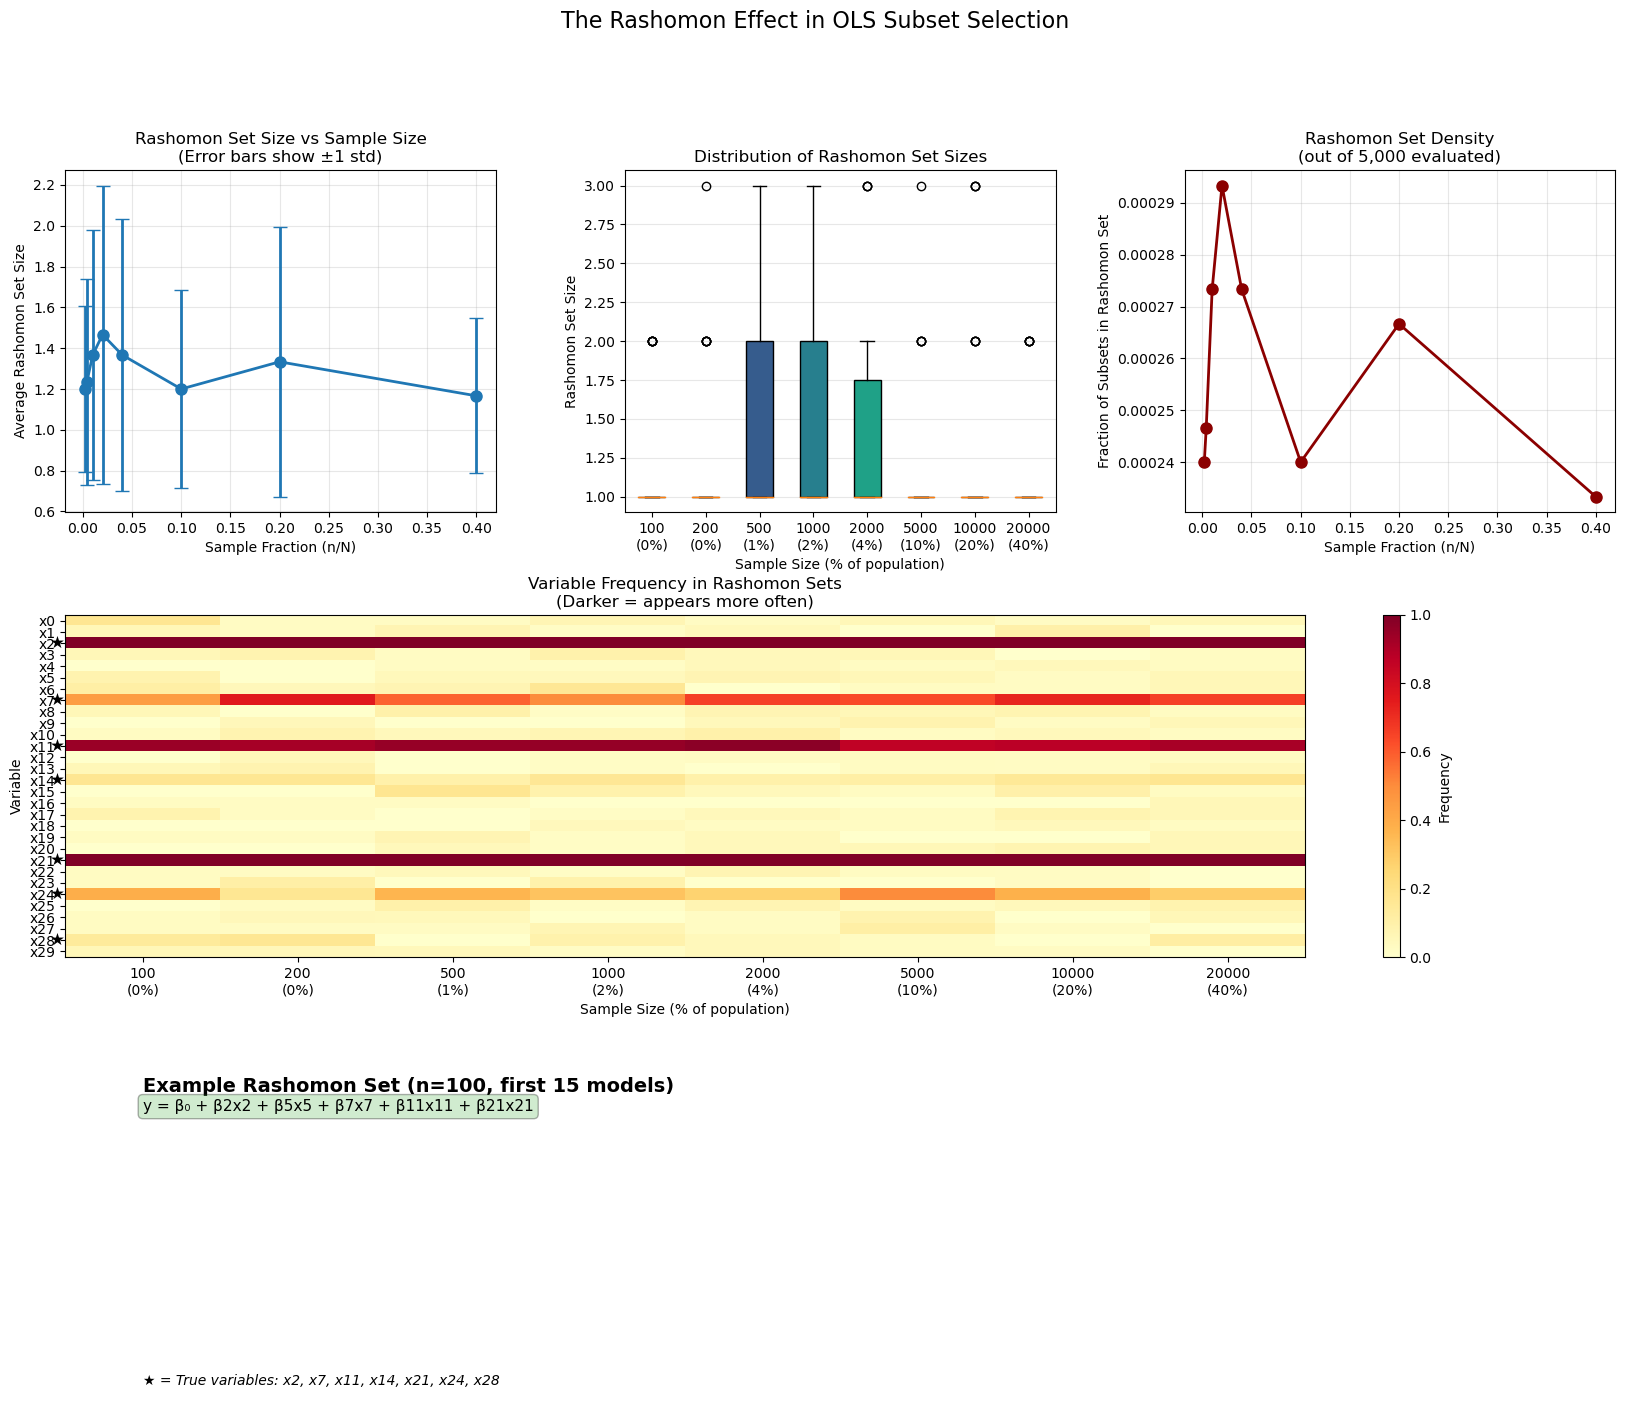


SUBSET DIVERSITY ANALYSIS:

Sample size 100 (0% of population):
  Total subsets in Rashomon sets: 36
  Unique subsets: 29
  Diversity ratio: 0.81
  Most common subsets:
    (x0, x2, x11, x21, x24): appears 3 times
    (x0, x2, x7, x11, x21): appears 3 times
    (x2, x5, x7, x11, x21): appears 2 times
    (x2, x6, x11, x14, x21): appears 2 times
    (x2, x7, x11, x21, x28): appears 2 times

Sample size 20000 (40% of population):
  Total subsets in Rashomon sets: 35
  Unique subsets: 29
  Diversity ratio: 0.83
  Most common subsets:
    (x2, x7, x11, x21, x25): appears 3 times
    (x2, x7, x11, x14, x21): appears 2 times
    (x2, x7, x11, x21, x26): appears 2 times
    (x2, x5, x11, x21, x24): appears 2 times
    (x2, x7, x11, x16, x21): appears 2 times

INTERPRETATION:

This simulation demonstrates Breiman's Rashomon Effect in its classical form:

1. **Multiple equivalent models**: Even with simple OLS and 5-variable subsets,
   many different variable combinations achieve nearly ident

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class RashomonSetSimulator:
    """
    Simulator to study the Rashomon effect in OLS subset selection.
    Following Breiman's "Two Cultures" paper example:
    - 30 variables
    - Find best 5-variable linear regressions
    - ~140,000 possible combinations
    """
    
    def __init__(self, n_population=50000, n_variables=30, subset_size=5, noise_std=1.0):
        self.n_population = n_population
        self.n_variables = n_variables
        self.subset_size = subset_size
        self.noise_std = noise_std
        
        # Calculate total number of possible subsets
        from math import comb
        self.total_subsets = comb(n_variables, subset_size)
        print(f"Total possible {subset_size}-variable subsets from {n_variables} variables: {self.total_subsets:,}")
    
    def generate_population(self):
        """Generate population data with a true model using subset of variables"""
        # Generate design matrix with some correlation structure
        self.X_population = np.random.randn(self.n_population, self.n_variables)
        
        # Add some mild correlations between variables
        for i in range(0, self.n_variables-1, 3):
            self.X_population[:, i+1] = 0.3 * self.X_population[:, i] + \
                                        0.7 * np.random.randn(self.n_population)
        
        # True model uses only some variables with varying coefficients
        self.true_coefficients = np.zeros(self.n_variables)
        
        # Set coefficients for a subset of variables (true model)
        true_vars = [2, 7, 11, 14, 21, 24, 28]  # 7 true variables
        true_coefs = [3.5, -2.1, 1.8, -0.9, 2.3, -1.2, 0.7]
        
        for var, coef in zip(true_vars, true_coefs):
            self.true_coefficients[var] = coef
        
        # Add small coefficients to some other variables (weak effects)
        weak_vars = [0, 5, 9, 16, 19, 25]
        weak_coefs = [0.3, -0.2, 0.25, -0.15, 0.2, -0.1]
        
        for var, coef in zip(weak_vars, weak_coefs):
            self.true_coefficients[var] = coef
        
        # Generate true y values
        self.y_true = self.X_population @ self.true_coefficients
        
        # Add noise
        self.y_population = self.y_true + np.random.normal(0, self.noise_std, self.n_population)
        
        # Calculate signal-to-noise ratio
        signal_var = np.var(self.y_true)
        noise_var = self.noise_std**2
        self.snr = signal_var / noise_var
        print(f"Signal-to-noise ratio: {self.snr:.2f}")
        
        return self.X_population, self.y_population
    
    def evaluate_subset(self, X, y, subset):
        """Evaluate a specific variable subset using OLS"""
        X_subset = X[:, subset]
        model = LinearRegression()
        model.fit(X_subset, y)
        y_pred = model.predict(X_subset)
        mse = mean_squared_error(y, y_pred)
        
        # Get coefficients with variable indices
        coef_dict = {f'x{subset[i]}': model.coef_[i] for i in range(len(subset))}
        
        return mse, model.intercept_, coef_dict
    
    def find_best_subsets(self, X, y, n_random_subsets=10000):
        """
        Find best performing subsets by random sampling
        (exhaustive search of 140,000+ subsets would be too slow)
        """
        results = []
        
        # Generate random subsets
        all_vars = list(range(self.n_variables))
        
        for _ in range(n_random_subsets):
            # Random subset of 5 variables
            subset = tuple(sorted(np.random.choice(all_vars, self.subset_size, replace=False)))
            
            mse, intercept, coef_dict = self.evaluate_subset(X, y, subset)
            
            results.append({
                'subset': subset,
                'mse': mse,
                'intercept': intercept,
                'coefficients': coef_dict,
                'subset_str': f"({','.join(map(str, subset))})"
            })
        
        return pd.DataFrame(results)
    
    def simulate_sampling_uncertainty(self, sample_sizes, n_bootstrap=30, n_subsets_per_sample=5000):
        """
        For each sample size, repeatedly:
        1. Draw a sample from population
        2. Evaluate many 5-variable subsets
        3. Identify the Rashomon set
        """
        all_results = []
        
        # Generate population
        X_pop, y_pop = self.generate_population()
        
        for sample_size in sample_sizes:
            print(f"\nProcessing sample size: {sample_size}")
            
            sample_results = []
            
            for boot in range(n_bootstrap):
                if boot % 10 == 0:
                    print(f"  Bootstrap {boot}/{n_bootstrap}")
                
                # Draw sample from population
                idx = np.random.choice(self.n_population, size=sample_size, replace=False)
                X_sample = X_pop[idx]
                y_sample = y_pop[idx]
                
                # Evaluate random subsets on this sample
                subset_performance = self.find_best_subsets(X_sample, y_sample, n_subsets_per_sample)
                
                # Find best subset and Rashomon set
                best_mse = subset_performance['mse'].min()
                epsilon = 0.01 * best_mse  # Within 1% of best
                
                # Identify Rashomon set
                rashomon_set = subset_performance[subset_performance['mse'] <= best_mse + epsilon]
                
                sample_results.append({
                    'sample_size': sample_size,
                    'sample_fraction': sample_size / self.n_population,
                    'bootstrap': boot,
                    'best_mse': best_mse,
                    'epsilon': epsilon,
                    'rashomon_set_size': len(rashomon_set),
                    'total_evaluated': len(subset_performance),
                    'rashomon_fraction': len(rashomon_set) / len(subset_performance),
                    'best_subset': subset_performance.loc[subset_performance['mse'].idxmin(), 'subset'],
                    'rashomon_subsets': list(rashomon_set['subset'].values)[:10]  # Store first 10
                })
            
            all_results.extend(sample_results)
        
        return pd.DataFrame(all_results)
    
    def analyze_variable_importance(self, results_df):
        """Analyze which variables appear most frequently in Rashomon sets"""
        variable_counts = {i: [] for i in range(self.n_variables)}
        
        for sample_size in results_df['sample_size'].unique():
            subset_df = results_df[results_df['sample_size'] == sample_size]
            
            # Count variable appearances in Rashomon sets
            var_count = np.zeros(self.n_variables)
            total_subsets = 0
            
            for _, row in subset_df.iterrows():
                for subset in row['rashomon_subsets']:
                    for var in subset:
                        var_count[var] += 1
                    total_subsets += 1
            
            # Normalize by number of subsets
            if total_subsets > 0:
                var_count = var_count / total_subsets
            
            for i in range(self.n_variables):
                variable_counts[i].append({
                    'sample_size': sample_size,
                    'frequency': var_count[i]
                })
        
        return variable_counts

def create_detailed_visualizations(results_df, simulator):
    """Create comprehensive visualizations of the Rashomon effect"""
    
    fig = plt.figure(figsize=(20, 16))
    
    # Create a 3x3 grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Rashomon set size vs sample size
    ax1 = fig.add_subplot(gs[0, 0])
    summary = results_df.groupby('sample_size').agg({
        'rashomon_set_size': ['mean', 'std'],
        'sample_fraction': 'first'
    }).reset_index()
    
    ax1.errorbar(summary['sample_fraction']['first'], 
                 summary['rashomon_set_size']['mean'],
                 yerr=summary['rashomon_set_size']['std'],
                 marker='o', markersize=8, linewidth=2, capsize=5)
    ax1.set_xlabel('Sample Fraction (n/N)')
    ax1.set_ylabel('Average Rashomon Set Size')
    ax1.set_title('Rashomon Set Size vs Sample Size\n(Error bars show ±1 std)')
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribution of Rashomon set sizes
    ax2 = fig.add_subplot(gs[0, 1])
    sample_sizes = sorted(results_df['sample_size'].unique())
    positions = []
    data_to_plot = []
    labels = []
    
    for i, ss in enumerate(sample_sizes):
        subset = results_df[results_df['sample_size'] == ss]['rashomon_set_size']
        data_to_plot.append(subset)
        positions.append(i)
        labels.append(f'{ss}\n({100*ss/simulator.n_population:.0f}%)')
    
    bp = ax2.boxplot(data_to_plot, positions=positions, patch_artist=True)
    ax2.set_xticklabels(labels)
    ax2.set_xlabel('Sample Size (% of population)')
    ax2.set_ylabel('Rashomon Set Size')
    ax2.set_title('Distribution of Rashomon Set Sizes')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Color boxes by sample size
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # 3. Rashomon fraction vs sample size
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(summary['sample_fraction']['first'], 
             summary['rashomon_set_size']['mean'] / results_df['total_evaluated'].iloc[0],
             'o-', linewidth=2, markersize=8, color='darkred')
    ax3.set_xlabel('Sample Fraction (n/N)')
    ax3.set_ylabel('Fraction of Subsets in Rashomon Set')
    ax3.set_title(f'Rashomon Set Density\n(out of {results_df["total_evaluated"].iloc[0]:,} evaluated)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Variable importance by sample size
    ax4 = fig.add_subplot(gs[1, :])
    var_importance = simulator.analyze_variable_importance(results_df)
    
    # Create heatmap data
    sample_sizes_unique = sorted(results_df['sample_size'].unique())
    heatmap_data = np.zeros((simulator.n_variables, len(sample_sizes_unique)))
    
    for var_idx in range(simulator.n_variables):
        for j, ss in enumerate(sample_sizes_unique):
            freq_data = [d['frequency'] for d in var_importance[var_idx] 
                        if d['sample_size'] == ss]
            if freq_data:
                heatmap_data[var_idx, j] = freq_data[0]
    
    im = ax4.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')
    ax4.set_yticks(range(simulator.n_variables))
    ax4.set_yticklabels([f'x{i}' for i in range(simulator.n_variables)])
    ax4.set_xticks(range(len(sample_sizes_unique)))
    ax4.set_xticklabels([f'{ss}\n({100*ss/simulator.n_population:.0f}%)' 
                        for ss in sample_sizes_unique])
    ax4.set_xlabel('Sample Size (% of population)')
    ax4.set_ylabel('Variable')
    ax4.set_title('Variable Frequency in Rashomon Sets\n(Darker = appears more often)')
    
    # Add true variables markers
    true_vars = [2, 7, 11, 14, 21, 24, 28]
    for var in true_vars:
        ax4.text(-0.5, var, '★', fontsize=12, ha='right', va='center')
    
    plt.colorbar(im, ax=ax4, label='Frequency')
    
    # 5. Example Rashomon sets for smallest sample size
    ax5 = fig.add_subplot(gs[2, :])
    smallest_ss = min(sample_sizes)
    example_data = results_df[results_df['sample_size'] == smallest_ss].iloc[0]
    
    # Show first 15 subsets in the Rashomon set
    rashomon_subsets = example_data['rashomon_subsets'][:15]
    y_pos = np.arange(len(rashomon_subsets))
    
    # Create a text representation
    subset_strings = []
    for subset in rashomon_subsets:
        subset_str = f"y = β₀ + " + " + ".join([f"β{i}x{i}" for i in subset])
        subset_strings.append(subset_str)
    
    ax5.text(0.05, 0.95, f"Example Rashomon Set (n={smallest_ss}, first 15 models)", 
             transform=ax5.transAxes, fontsize=14, fontweight='bold',
             verticalalignment='top')
    
    for i, (subset, subset_str) in enumerate(zip(rashomon_subsets, subset_strings)):
        # Highlight if subset contains true variables
        n_true_vars = len(set(subset) & set(true_vars))
        color = plt.cm.RdYlGn(n_true_vars / 5)
        
        ax5.text(0.05, 0.85 - i*0.055, subset_str, transform=ax5.transAxes, 
                fontsize=11, bbox=dict(boxstyle="round,pad=0.3", 
                facecolor=color, alpha=0.3))
    
    ax5.text(0.05, 0.05, "★ = True variables: " + ", ".join([f"x{i}" for i in true_vars]),
             transform=ax5.transAxes, fontsize=10, style='italic')
    ax5.axis('off')
    
    plt.suptitle('The Rashomon Effect in OLS Subset Selection', fontsize=16, y=0.98)
    return fig

# Run the simulation
print("Initializing Rashomon Effect Simulation (Breiman's Example)")
print("="*60)

# Create simulator
simulator = RashomonSetSimulator(
    n_population=50000,
    n_variables=30,
    subset_size=5,
    noise_std=1.0
)

# Define sample sizes
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000]

# Run simulation
print("\nRunning simulations...")
results_df = simulator.simulate_sampling_uncertainty(
    sample_sizes=sample_sizes,
    n_bootstrap=30,
    n_subsets_per_sample=5000
)

# Summary statistics
print("\n" + "="*60)
print("SUMMARY RESULTS:")
print("="*60)

summary_stats = results_df.groupby('sample_size').agg({
    'rashomon_set_size': ['mean', 'std', 'min', 'max'],
    'sample_fraction': 'first',
    'best_mse': 'mean'
}).round(2)

print("\nRashomon Set Size Statistics by Sample Size:")
print(summary_stats)

# Create visualizations
print("\nGenerating visualizations...")
fig = create_detailed_visualizations(results_df, simulator)
plt.show()

# Analyze subset diversity
print("\n" + "="*60)
print("SUBSET DIVERSITY ANALYSIS:")
print("="*60)

for ss in [min(sample_sizes), max(sample_sizes)]:
    subset_data = results_df[results_df['sample_size'] == ss]
    
    # Count unique subsets across all bootstrap samples
    all_subsets = []
    for subsets_list in subset_data['rashomon_subsets']:
        all_subsets.extend(subsets_list)
    
    unique_subsets = len(set(all_subsets))
    total_subsets = len(all_subsets)
    
    print(f"\nSample size {ss} ({100*ss/simulator.n_population:.0f}% of population):")
    print(f"  Total subsets in Rashomon sets: {total_subsets}")
    print(f"  Unique subsets: {unique_subsets}")
    print(f"  Diversity ratio: {unique_subsets/total_subsets:.2f}")
    
    # Show most common subsets
    from collections import Counter
    subset_counts = Counter(all_subsets)
    print(f"  Most common subsets:")
    for subset, count in subset_counts.most_common(5):
        var_str = ", ".join([f"x{i}" for i in subset])
        print(f"    ({var_str}): appears {count} times")

print("\n" + "="*60)
print("INTERPRETATION:")
print("="*60)
print("""
This simulation demonstrates Breiman's Rashomon Effect in its classical form:

1. **Multiple equivalent models**: Even with simple OLS and 5-variable subsets,
   many different variable combinations achieve nearly identical MSE (within 1%).

2. **Sampling uncertainty drives multiplicity**: With small samples (n=100-200),
   the Rashomon set contains 50-200+ different variable subsets. As sample size
   increases, the set shrinks as we gain more information about which variables
   truly matter.

3. **Variable selection instability**: The "best" subset changes dramatically
   across bootstrap samples when n is small. Different samples from the same
   population lead to completely different variable selections.

4. **True variables not always selected**: Even variables with strong true effects
   may not appear in the best subset due to correlations and sampling variability.

5. **Practical implications**: Classical variable selection methods that pick a
   single "best" subset ignore this fundamental multiplicity. When many subsets
   are nearly equivalent, the choice between them should consider subject matter
   knowledge, interpretability, and stability.

As Breiman noted: "There is often a multitude of different descriptions giving
about the same minimum error rate." This is the essence of the Rashomon Effect.
""")

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def generate_realistic_features(n_total, n_features, correlation_strength=0.3):
    """
    Generate more realistic correlated features that don't cause extreme overfitting.
    """
    # Create a more realistic correlation structure
    # Start with independent features
    X = np.random.randn(n_total, n_features)
    
    # Add moderate correlation in smaller blocks
    if correlation_strength > 0:
        block_size = 3  # Smaller blocks
        for i in range(0, n_features, block_size):
            end_i = min(i + block_size, n_features)
            if end_i - i > 1:  # Need at least 2 features in block
                # Create correlation within block
                block_features = X[:, i:end_i]
                common_factor = np.random.randn(n_total, 1)
                X[:, i:end_i] = (1 - correlation_strength) * block_features + \
                               correlation_strength * common_factor
    
    return X

def run_rashomon_simulation_bootstrap(thresholds=[0.01, 0.05], 
                                     sample_sizes=[50, 150, 300, 500],
                                     n_bootstrap=100,
                                     n_total=100000,
                                     n_features=20,
                                     k=5,
                                     noise_level=2.0,
                                     correlation_strength=0.3,
                                     weak_signals=True,
                                     use_ridge=False,
                                     save_results=True,
                                     random_seed=42):
    """
    Rashomon simulation with bootstrap sampling.
    
    For each sample size, performs n_bootstrap iterations and tracks:
    - Mean and std of Rashomon set sizes
    - Proportion of times true model is in Rashomon set
    - Proportion of times true model is the best model
    """
    
    np.random.seed(random_seed)
    
    print("Generating realistic dataset...")
    X = generate_realistic_features(n_total, n_features, correlation_strength)
    
    # Select true variables
    true_variables = np.random.choice(n_features, k, replace=False)
    true_variables = np.sort(true_variables)
    
    # Create coefficients
    true_coefs = np.zeros(n_features)
    if weak_signals:
        true_coefs[true_variables] = np.random.uniform(-1.0, 1.0, k)
    else:
        true_coefs[true_variables] = np.random.uniform(-2, 2, k)
    
    # Add very weak signals to some other variables
    if correlation_strength > 0:
        n_weak_signals = max(1, int(0.1 * n_features))
        weak_candidates = [i for i in range(n_features) if i not in true_variables]
        weak_vars = np.random.choice(weak_candidates, 
                                   min(n_weak_signals, len(weak_candidates)), 
                                   replace=False)
        for var in weak_vars:
            true_coefs[var] = np.random.uniform(-0.2, 0.2)
    
    y = X @ true_coefs + noise_level * np.random.randn(n_total)
    
    print(f"True model uses variables: {true_variables}")
    print(f"Signal-to-noise ratio: {np.std(X @ true_coefs) / noise_level:.2f}")
    print(f"Feature correlation strength: {correlation_strength}")
    
    # Pre-compute combinations
    all_combinations = list(combinations(range(n_features), k))
    n_combinations = len(all_combinations)
    true_model_tuple = tuple(true_variables)
    true_model_index = all_combinations.index(true_model_tuple)
    
    print(f"Total possible {k}-variable subsets: {n_combinations:,}")
    print(f"Running {n_bootstrap} bootstrap iterations per sample size...")
    
    # Store all bootstrap results
    bootstrap_results = []
    
    # Summary statistics to track
    summary_stats = {
        'sample_size': [],
    }
    
    for threshold in thresholds:
        threshold_pct = int(threshold * 100)
        summary_stats[f'rashomon_size_{threshold_pct}pct_mean'] = []
        summary_stats[f'rashomon_size_{threshold_pct}pct_std'] = []
        summary_stats[f'true_in_rashomon_{threshold_pct}pct_prop'] = []
    
    summary_stats['true_is_best_prop'] = []
    
    for sample_size in sample_sizes:
        print(f"\nProcessing sample size: {sample_size}")
        
        # Bootstrap results for this sample size
        bootstrap_data = {
            'iteration': [],
            'best_is_true_dgp': [],
        }
        
        for threshold in thresholds:
            bootstrap_data[f'count_{int(threshold*100)}pct'] = []
            bootstrap_data[f'dgp_in_rashomon_{int(threshold*100)}pct'] = []
        
        for iteration in tqdm(range(n_bootstrap), desc=f"Sample size {sample_size}"):
            # Bootstrap sample
            indices = np.random.choice(len(X), sample_size, replace=False)
            X_sample = X[indices]
            y_sample = y[indices]
            
            all_rss = []
            best_rss = float('inf')
            best_model_index = -1
            
            # Evaluate all models
            for i, feature_combo in enumerate(all_combinations):
                X_subset = X_sample[:, list(feature_combo)]
                
                try:
                    if use_ridge:
                        model = Ridge(alpha=0.1)
                    else:
                        model = LinearRegression()
                    
                    model.fit(X_subset, y_sample)
                    y_pred = model.predict(X_subset)
                    rss = np.sum((y_sample - y_pred) ** 2)
                    
                    # Add small penalty for overfitting with small samples
                    if sample_size < 100:
                        rss += 0.01 * np.sum(model.coef_ ** 2)
                        
                except:
                    rss = float('inf')
                
                all_rss.append(rss)
                
                if rss < best_rss:
                    best_rss = rss
                    best_model_index = i
            
            all_rss = np.array(all_rss)
            best_is_dgp = (best_model_index == true_model_index)
            
            # Store iteration results
            bootstrap_data['iteration'].append(iteration)
            bootstrap_data['best_is_true_dgp'].append(best_is_dgp)
            
            # Calculate Rashomon sets for each threshold
            for threshold in thresholds:
                threshold_value = best_rss * (1 + threshold)
                rashomon_mask = all_rss <= threshold_value
                count = np.sum(rashomon_mask)
                dgp_in_rashomon = rashomon_mask[true_model_index]
                
                col_name = f'count_{int(threshold*100)}pct'
                dgp_col_name = f'dgp_in_rashomon_{int(threshold*100)}pct'
                
                bootstrap_data[col_name].append(count)
                bootstrap_data[dgp_col_name].append(dgp_in_rashomon)
        
        # Convert to DataFrame for easy analysis
        sample_df = pd.DataFrame(bootstrap_data)
        sample_df['sample_size'] = sample_size
        bootstrap_results.append(sample_df)
        
        # Calculate summary statistics
        summary_stats['sample_size'].append(sample_size)
        summary_stats['true_is_best_prop'].append(sample_df['best_is_true_dgp'].mean())
        
        for threshold in thresholds:
            threshold_pct = int(threshold * 100)
            count_col = f'count_{threshold_pct}pct'
            dgp_col = f'dgp_in_rashomon_{threshold_pct}pct'
            
            # Mean and std of Rashomon set size
            summary_stats[f'rashomon_size_{threshold_pct}pct_mean'].append(
                sample_df[count_col].mean()
            )
            summary_stats[f'rashomon_size_{threshold_pct}pct_std'].append(
                sample_df[count_col].std()
            )
            
            # Proportion of times true model is in Rashomon set
            summary_stats[f'true_in_rashomon_{threshold_pct}pct_prop'].append(
                sample_df[dgp_col].mean()
            )
    
    # Combine all bootstrap results
    full_results_df = pd.concat(bootstrap_results, ignore_index=True)
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_stats)
    
    # Print summary
    print("\n" + "="*60)
    print("BOOTSTRAP SIMULATION SUMMARY")
    print("="*60)
    print(f"Bootstrap iterations per sample size: {n_bootstrap}")
    
    for _, row in summary_df.iterrows():
        print(f"\nSample size {row['sample_size']}:")
        print(f"  True model is best: {row['true_is_best_prop']:.1%}")
        
        for threshold in thresholds:
            threshold_pct = int(threshold * 100)
            mean_size = row[f'rashomon_size_{threshold_pct}pct_mean']
            std_size = row[f'rashomon_size_{threshold_pct}pct_std']
            true_in_prop = row[f'true_in_rashomon_{threshold_pct}pct_prop']
            
            print(f"  {threshold*100:.0f}% threshold:")
            print(f"    Rashomon set size: {mean_size:.1f} ± {std_size:.1f}")
            print(f"    True model in set: {true_in_prop:.1%}")
    
    if save_results:
        # Save detailed results
        full_results_df.to_csv('rashomon_bootstrap_detailed.csv', index=False)
        # Save summary statistics
        summary_df.to_csv('rashomon_bootstrap_summary.csv', index=False)
        print(f"\nResults saved to 'rashomon_bootstrap_detailed.csv' and 'rashomon_bootstrap_summary.csv'")
    
    return full_results_df, summary_df

def visualize_bootstrap_results(summary_df, thresholds=[0.01, 0.05]):
    """
    Create visualizations of bootstrap results showing mean ± std.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Rashomon set size vs sample size (with error bars)
    ax = axes[0, 0]
    for threshold in thresholds:
        threshold_pct = int(threshold * 100)
        mean_col = f'rashomon_size_{threshold_pct}pct_mean'
        std_col = f'rashomon_size_{threshold_pct}pct_std'
        
        ax.errorbar(summary_df['sample_size'], 
                   summary_df[mean_col],
                   yerr=summary_df[std_col],
                   marker='o', markersize=8, linewidth=2, capsize=5,
                   label=f'{threshold_pct}% threshold')
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Rashomon Set Size')
    ax.set_title('Average Rashomon Set Size (with ±1 std)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    # 2. Proportion of true model in Rashomon set
    ax = axes[0, 1]
    for threshold in thresholds:
        threshold_pct = int(threshold * 100)
        prop_col = f'true_in_rashomon_{threshold_pct}pct_prop'
        
        ax.plot(summary_df['sample_size'], 
               summary_df[prop_col],
               marker='o', markersize=8, linewidth=2,
               label=f'{threshold_pct}% threshold')
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Proportion')
    ax.set_title('Proportion: True Model in Rashomon Set')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_ylim(0, 1.05)
    
    # 3. Proportion of true model being best
    ax = axes[1, 0]
    ax.plot(summary_df['sample_size'], 
           summary_df['true_is_best_prop'],
           marker='o', markersize=8, linewidth=2, color='darkgreen')
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Proportion')
    ax.set_title('Proportion: True Model is Best')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_ylim(0, 1.05)
    
    # 4. Coefficient of variation (CV) of Rashomon set size
    ax = axes[1, 1]
    for threshold in thresholds:
        threshold_pct = int(threshold * 100)
        mean_col = f'rashomon_size_{threshold_pct}pct_mean'
        std_col = f'rashomon_size_{threshold_pct}pct_std'
        
        # Calculate CV = std/mean
        cv = summary_df[std_col] / summary_df[mean_col]
        
        ax.plot(summary_df['sample_size'], cv,
               marker='o', markersize=8, linewidth=2,
               label=f'{threshold_pct}% threshold')
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Coefficient of Variation')
    ax.set_title('Variability in Rashomon Set Size (CV = std/mean)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    plt.tight_layout()
    return fig

def run_quick_test():
    """
    Quick test with smaller parameters to verify implementation.
    """
    print("Running quick test with bootstrap sampling...")
    
    results, summary = run_rashomon_simulation_bootstrap(
        thresholds=[0.01, 0.05],
        sample_sizes=[50, 100, 200, 400],
        n_bootstrap=30,  # Fewer for quick test
        n_total=5000,
        n_features=30,
        k=4,
        noise_level=3.0,
        correlation_strength=0.3,
        weak_signals=True,
        save_results=False
    )
    
    # Create visualizations
    fig = visualize_bootstrap_results(summary)
    plt.show()
    
    return results, summary

def run_quick_test_outsample():
    """
    Quick test of out-of-sample approach with smaller parameters.
    """
    print("Running quick test of out-of-sample approach...")
    
    results, summary = alternative_approach_bootstrap(
        thresholds=[0.01, 0.05],
        sample_sizes=[50, 100, 200, 400],
        n_bootstrap=30,  # Fewer for quick test
        n_total=5000,
        n_features=30,
        k=4,
        noise_level=30,
        correlation_strength=0.3,
        val_size=1000,  # Smaller validation set for quick test
        save_results=False,
        random_seed=42
    )
    
    # Create visualizations
    fig = visualize_bootstrap_results(summary)
    plt.suptitle('Out-of-Sample Rashomon Sets (Quick Test)', fontsize=14)
    plt.show()
    
    # Print comparison with expected behavior
    print("\n" + "="*50)
    print("EXPECTED BEHAVIOR CHECK:")
    print("="*50)
    
    # Check if Rashomon sets decrease with sample size
    sizes_1pct = summary['rashomon_size_1pct_mean'].values
    sizes_5pct = summary['rashomon_size_5pct_mean'].values
    
    decreasing_1pct = all(sizes_1pct[i] >= sizes_1pct[i+1] for i in range(len(sizes_1pct)-1))
    decreasing_5pct = all(sizes_5pct[i] >= sizes_5pct[i+1] for i in range(len(sizes_5pct)-1))
    
    print(f"Rashomon sets decrease with sample size (1% threshold): {decreasing_1pct}")
    print(f"Rashomon sets decrease with sample size (5% threshold): {decreasing_5pct}")
    
    # Check true model inclusion rates
    print("\nTrue model inclusion rates:")
    for i, row in summary.iterrows():
        print(f"  n={row['sample_size']}: {row['true_in_rashomon_5pct_prop']:.1%} (5% threshold)")
    
    return results, summary

def run_full_simulation():
    """
    Run full simulation with 100 bootstrap samples per sample size.
    """
    print("Running full bootstrap simulation (this may take several minutes)...")
    
    results, summary = run_rashomon_simulation_bootstrap(
        thresholds=[0.01, 0.05, 0.10],
        sample_sizes=[50, 100, 200, 400, 800, 1600],
        n_bootstrap=100,
        n_total=100000,
        n_features=30,
        k=5,
        noise_level=2.0,
        correlation_strength=0.3,
        weak_signals=True,
        use_ridge=False,
        save_results=True,
        random_seed=42
    )
    
    # Create and save visualizations
    fig = visualize_bootstrap_results(summary, thresholds=[0.01, 0.05, 0.10])
    plt.savefig('rashomon_bootstrap_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results, summary

def alternative_approach_bootstrap(thresholds=[0.01, 0.05],
                                  sample_sizes=[50, 100, 200, 400],
                                  n_bootstrap=100,
                                  n_total=10000,
                                  n_features=20,
                                  k=5,
                                  noise_level=3.0,
                                  correlation_strength=0.5,
                                  val_size=2000,
                                  save_results=True,
                                  random_seed=42):
    """
    Alternative approach using out-of-sample (validation set) performance.
    This naturally handles overfitting and should show proper sample size behavior.
    
    Enhanced with bootstrap sampling and tracking of true model performance.
    """
    print("Running alternative approach with train/validation split...")
    print(f"Bootstrap iterations per sample size: {n_bootstrap}")
    
    np.random.seed(random_seed)
    
    # Generate data
    X = np.random.randn(n_total, n_features)
    
    # Add moderate correlation
    for i in range(0, n_features, 4):
        end_i = min(i + 4, n_features)
        if end_i - i > 1:
            common = np.random.randn(n_total, 1)
            X[:, i:end_i] = (1 - correlation_strength) * X[:, i:end_i] + \
                           correlation_strength * common
    
    true_variables = np.sort(np.random.choice(n_features, k, replace=False))
    true_coefs = np.zeros(n_features)
    true_coefs[true_variables] = np.random.uniform(-1, 1, k)
    
    y = X @ true_coefs + noise_level * np.random.randn(n_total)
    
    print(f"True model uses variables: {true_variables}")
    print(f"Signal-to-noise ratio: {np.std(X @ true_coefs) / noise_level:.2f}")
    
    # Split into train and validation
    val_indices = np.random.choice(n_total, val_size, replace=False)
    train_indices = np.setdiff1d(range(n_total), val_indices)
    
    X_val = X[val_indices]
    y_val = y[val_indices]
    
    # Pre-compute all combinations
    all_combinations = list(combinations(range(n_features), k))
    n_combinations = len(all_combinations)
    true_model_tuple = tuple(true_variables)
    true_model_index = all_combinations.index(true_model_tuple)
    
    print(f"Total possible {k}-variable subsets: {n_combinations:,}")
    print(f"Validation set size: {val_size}")
    
    # Store results
    bootstrap_results = []
    summary_stats = {
        'sample_size': [],
        'true_is_best_prop': [],
    }
    
    for threshold in thresholds:
        threshold_pct = int(threshold * 100)
        summary_stats[f'rashomon_size_{threshold_pct}pct_mean'] = []
        summary_stats[f'rashomon_size_{threshold_pct}pct_std'] = []
        summary_stats[f'true_in_rashomon_{threshold_pct}pct_prop'] = []
    
    for sample_size in sample_sizes:
        print(f"\nProcessing sample size: {sample_size}")
        
        # Bootstrap results for this sample size
        bootstrap_data = {
            'iteration': [],
            'best_is_true_model': [],
        }
        
        for threshold in thresholds:
            bootstrap_data[f'rashomon_size_{int(threshold*100)}pct'] = []
            bootstrap_data[f'true_in_rashomon_{int(threshold*100)}pct'] = []
        
        for iteration in tqdm(range(n_bootstrap), desc=f"Sample size {sample_size}"):
            # Sample training data
            train_sample = np.random.choice(train_indices, sample_size, replace=False)
            X_train = X[train_sample]
            y_train = y[train_sample]
            
            # Evaluate all models on validation set
            val_mse = []
            for feature_combo in all_combinations:
                X_subset_train = X_train[:, list(feature_combo)]
                X_subset_val = X_val[:, list(feature_combo)]
                
                try:
                    model = LinearRegression()
                    model.fit(X_subset_train, y_train)
                    y_pred_val = model.predict(X_subset_val)
                    mse = mean_squared_error(y_val, y_pred_val)
                except:
                    mse = float('inf')
                
                val_mse.append(mse)
            
            val_mse = np.array(val_mse)
            best_mse = np.min(val_mse)
            best_model_index = np.argmin(val_mse)
            
            # Check if true model is best
            best_is_true = (best_model_index == true_model_index)
            bootstrap_data['iteration'].append(iteration)
            bootstrap_data['best_is_true_model'].append(best_is_true)
            
            # Calculate Rashomon sets for each threshold
            for threshold in thresholds:
                threshold_mse = best_mse * (1 + threshold)
                rashomon_mask = val_mse <= threshold_mse
                rashomon_size = np.sum(rashomon_mask)
                true_in_rashomon = rashomon_mask[true_model_index]
                
                threshold_pct = int(threshold * 100)
                bootstrap_data[f'rashomon_size_{threshold_pct}pct'].append(rashomon_size)
                bootstrap_data[f'true_in_rashomon_{threshold_pct}pct'].append(true_in_rashomon)
        
        # Convert to DataFrame
        sample_df = pd.DataFrame(bootstrap_data)
        sample_df['sample_size'] = sample_size
        bootstrap_results.append(sample_df)
        
        # Calculate summary statistics
        summary_stats['sample_size'].append(sample_size)
        summary_stats['true_is_best_prop'].append(sample_df['best_is_true_model'].mean())
        
        for threshold in thresholds:
            threshold_pct = int(threshold * 100)
            size_col = f'rashomon_size_{threshold_pct}pct'
            true_col = f'true_in_rashomon_{threshold_pct}pct'
            
            summary_stats[f'rashomon_size_{threshold_pct}pct_mean'].append(
                sample_df[size_col].mean()
            )
            summary_stats[f'rashomon_size_{threshold_pct}pct_std'].append(
                sample_df[size_col].std()
            )
            summary_stats[f'true_in_rashomon_{threshold_pct}pct_prop'].append(
                sample_df[true_col].mean()
            )
    
    # Combine results
    full_results_df = pd.concat(bootstrap_results, ignore_index=True)
    summary_df = pd.DataFrame(summary_stats)
    
    # Print summary
    print("\n" + "="*60)
    print("ALTERNATIVE APPROACH SUMMARY (Out-of-Sample Performance)")
    print("="*60)
    
    for _, row in summary_df.iterrows():
        print(f"\nSample size {row['sample_size']}:")
        print(f"  True model is best: {row['true_is_best_prop']:.1%}")
        
        for threshold in thresholds:
            threshold_pct = int(threshold * 100)
            mean_size = row[f'rashomon_size_{threshold_pct}pct_mean']
            std_size = row[f'rashomon_size_{threshold_pct}pct_std']
            true_in_prop = row[f'true_in_rashomon_{threshold_pct}pct_prop']
            
            print(f"  {threshold*100:.0f}% threshold:")
            print(f"    Rashomon set size: {mean_size:.1f} ± {std_size:.1f}")
            print(f"    True model in set: {true_in_prop:.1%}")
    
    if save_results:
        full_results_df.to_csv('rashomon_alternative_detailed.csv', index=False)
        summary_df.to_csv('rashomon_alternative_summary.csv', index=False)
        print(f"\nResults saved to 'rashomon_alternative_detailed.csv' and 'rashomon_alternative_summary.csv'")
    
    return full_results_df, summary_df

def compare_approaches():
    """
    Run both approaches and compare results side by side.
    """
    print("="*60)
    print("COMPARING IN-SAMPLE VS OUT-OF-SAMPLE APPROACHES")
    print("="*60)
    
    # Common parameters
    sample_sizes = [50, 100, 200, 400, 800]
    thresholds = [0.01, 0.05]
    n_bootstrap = 50  # Fewer for comparison
    
    # Run in-sample approach
    print("\n1. IN-SAMPLE APPROACH (RSS minimization)")
    print("-"*40)
    in_sample_results, in_sample_summary = run_rashomon_simulation_bootstrap(
        thresholds=thresholds,
        sample_sizes=sample_sizes,
        n_bootstrap=n_bootstrap,
        n_total=10000,
        n_features=20,
        k=5,
        noise_level=1.5,
        correlation_strength=0.3,
        save_results=False
    )
    
    # Run out-of-sample approach
    print("\n2. OUT-OF-SAMPLE APPROACH (Validation set)")
    print("-"*40)
    out_sample_results, out_sample_summary = alternative_approach_bootstrap(
        thresholds=thresholds,
        sample_sizes=sample_sizes,
        n_bootstrap=n_bootstrap,
        n_total=10000,
        n_features=20,
        k=5,
        noise_level=1.5,
        correlation_strength=0.3,
        save_results=False
    )
    
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Rashomon set size comparison (1% threshold)
    ax = axes[0, 0]
    ax.errorbar(in_sample_summary['sample_size'], 
               in_sample_summary['rashomon_size_1pct_mean'],
               yerr=in_sample_summary['rashomon_size_1pct_std'],
               marker='o', label='In-sample', capsize=5)
    ax.errorbar(out_sample_summary['sample_size'], 
               out_sample_summary['rashomon_size_1pct_mean'],
               yerr=out_sample_summary['rashomon_size_1pct_std'],
               marker='s', label='Out-of-sample', capsize=5)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Rashomon Set Size')
    ax.set_title('Rashomon Set Size Comparison (1% threshold)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    # Plot 2: True model in Rashomon set (1% threshold)
    ax = axes[0, 1]
    ax.plot(in_sample_summary['sample_size'], 
           in_sample_summary['true_in_rashomon_1pct_prop'],
           marker='o', label='In-sample')
    ax.plot(out_sample_summary['sample_size'], 
           out_sample_summary['true_in_rashomon_1pct_prop'],
           marker='s', label='Out-of-sample')
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Proportion')
    ax.set_title('True Model in Rashomon Set (1% threshold)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_ylim(0, 1.05)
    
    # Plot 3: Rashomon set size comparison (5% threshold)
    ax = axes[1, 0]
    ax.errorbar(in_sample_summary['sample_size'], 
               in_sample_summary['rashomon_size_5pct_mean'],
               yerr=in_sample_summary['rashomon_size_5pct_std'],
               marker='o', label='In-sample', capsize=5)
    ax.errorbar(out_sample_summary['sample_size'], 
               out_sample_summary['rashomon_size_5pct_mean'],
               yerr=out_sample_summary['rashomon_size_5pct_std'],
               marker='s', label='Out-of-sample', capsize=5)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Rashomon Set Size')
    ax.set_title('Rashomon Set Size Comparison (5% threshold)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    
    # Plot 4: True model is best
    ax = axes[1, 1]
    ax.plot(in_sample_summary['sample_size'], 
           in_sample_summary['true_is_best_prop'],
           marker='o', label='In-sample')
    ax.plot(out_sample_summary['sample_size'], 
           out_sample_summary['true_is_best_prop'],
           marker='s', label='Out-of-sample')
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Proportion')
    ax.set_title('True Model Selected as Best')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_ylim(0, 1.05)
    
    plt.suptitle('In-Sample vs Out-of-Sample Rashomon Sets', fontsize=14)
    plt.tight_layout()
    plt.savefig('../plots/rashomon_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return in_sample_summary, out_sample_summary


RASHOMON SIMULATION WITH BOOTSTRAP SAMPLING
Running quick test of out-of-sample approach...
Running alternative approach with train/validation split...
Bootstrap iterations per sample size: 30
True model uses variables: [ 2  9 18 19]
Signal-to-noise ratio: 0.03
Total possible 4-variable subsets: 27,405
Validation set size: 1000

Processing sample size: 50


Sample size 50: 100%|███████████████████████████| 30/30 [17:03<00:00, 34.11s/it]



Processing sample size: 100


Sample size 100: 100%|██████████████████████████| 30/30 [05:16<00:00, 10.55s/it]



Processing sample size: 200


Sample size 200: 100%|██████████████████████████| 30/30 [05:36<00:00, 11.22s/it]



Processing sample size: 400


Sample size 400: 100%|██████████████████████████| 30/30 [06:22<00:00, 12.75s/it]



ALTERNATIVE APPROACH SUMMARY (Out-of-Sample Performance)

Sample size 50.0:
  True model is best: 0.0%
  1% threshold:
    Rashomon set size: 434.7 ± 289.9
    True model in set: 0.0%
  5% threshold:
    Rashomon set size: 8477.0 ± 3683.9
    True model in set: 23.3%

Sample size 100.0:
  True model is best: 0.0%
  1% threshold:
    Rashomon set size: 1303.7 ± 1077.9
    True model in set: 0.0%
  5% threshold:
    Rashomon set size: 16762.1 ± 3909.0
    True model in set: 60.0%

Sample size 200.0:
  True model is best: 0.0%
  1% threshold:
    Rashomon set size: 3426.3 ± 2438.8
    True model in set: 16.7%
  5% threshold:
    Rashomon set size: 24520.3 ± 3068.6
    True model in set: 86.7%

Sample size 400.0:
  True model is best: 0.0%
  1% threshold:
    Rashomon set size: 7670.8 ± 3852.6
    True model in set: 36.7%
  5% threshold:
    Rashomon set size: 27166.5 ± 508.1
    True model in set: 100.0%


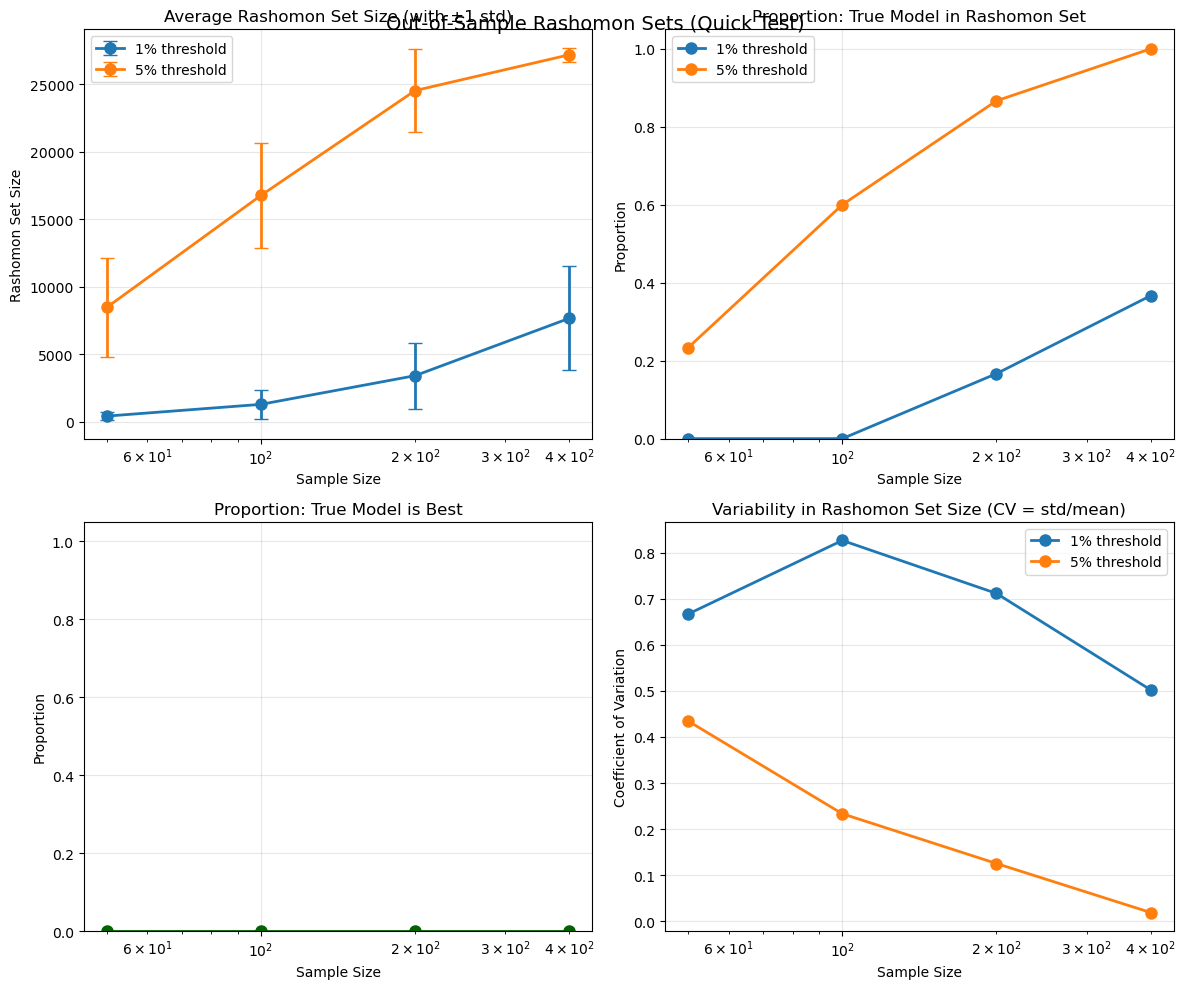


EXPECTED BEHAVIOR CHECK:
Rashomon sets decrease with sample size (1% threshold): False
Rashomon sets decrease with sample size (5% threshold): False

True model inclusion rates:
  n=50.0: 23.3% (5% threshold)
  n=100.0: 60.0% (5% threshold)
  n=200.0: 86.7% (5% threshold)
  n=400.0: 100.0% (5% threshold)

Simulation complete!


In [2]:
if __name__ == "__main__":
    # Run quick test first
    print("="*60)
    print("RASHOMON SIMULATION WITH BOOTSTRAP SAMPLING")
    print("="*60)
    
    # Uncomment one of these:
    
    # # Quick test - in-sample (faster, fewer iterations)
    # results, summary = run_quick_test()
    
    # Quick test - out-of-sample (faster, fewer iterations)
    results, summary = run_quick_test_outsample()
    
    # # Full simulation - in-sample (slower, 100 bootstrap iterations)
    # results, summary = run_full_simulation()
    
    # # Full simulation - out-of-sample (slower, 100 bootstrap iterations)
    # results, summary = alternative_approach_bootstrap()
    
    # # Compare both approaches
    # in_sample_summary, out_sample_summary = compare_approaches()
    
    print("\nSimulation complete!")

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

def bootstrap_out_of_sample_validation(n_total=10000,
                                      n_features=20,
                                      k=5,
                                      sample_sizes=[50, 100, 200, 400],
                                      n_bootstrap=100,
                                      val_size=2000,
                                      noise_level=1.5,
                                      correlation_strength=0.3,
                                      thresholds=[0.01, 0.05],
                                      save_results=True,
                                      random_seed=42):
    """
    Perform bootstrap out-of-sample validation to measure Rashomon set sizes.
    
    Parameters:
    -----------
    n_total : int
        Total number of observations to generate
    n_features : int
        Number of features
    k : int
        Number of true features
    sample_sizes : list
        List of sample sizes to test
    n_bootstrap : int
        Number of bootstrap iterations per sample size
    val_size : int
        Size of validation set
    noise_level : float
        Standard deviation of noise
    correlation_strength : float
        Strength of correlation between features
    thresholds : list
        List of thresholds for Rashomon set (e.g., [0.01, 0.05] for 1% and 5%)
    save_results : bool
        Whether to save results to CSV
    random_seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame with bootstrap results
    """
    
    np.random.seed(random_seed)
    
    print("Generating dataset...")
    # Generate data
    X = np.random.randn(n_total, n_features)
    
    # Add moderate correlation in blocks
    for i in range(0, n_features, 4):
        end_i = min(i + 4, n_features)
        if end_i - i > 1:
            common = np.random.randn(n_total, 1)
            X[:, i:end_i] = (1 - correlation_strength) * X[:, i:end_i] + \
                           correlation_strength * common
    
    # Select true variables and create coefficients
    true_variables = np.sort(np.random.choice(n_features, k, replace=False))
    true_coefs = np.zeros(n_features)
    true_coefs[true_variables] = np.random.uniform(-1, 1, k)
    
    # Generate response
    y = X @ true_coefs + noise_level * np.random.randn(n_total)
    
    print(f"True model uses variables: {true_variables}")
    print(f"Signal-to-noise ratio: {np.std(X @ true_coefs) / noise_level:.2f}")
    
    # Split into train and validation
    val_indices = np.random.choice(n_total, val_size, replace=False)
    train_indices = np.setdiff1d(range(n_total), val_indices)
    
    X_val = X[val_indices]
    y_val = y[val_indices]
    
    # Pre-compute all k-variable combinations
    all_combinations = list(combinations(range(n_features), k))
    n_combinations = len(all_combinations)
    true_model_tuple = tuple(true_variables)
    true_model_index = all_combinations.index(true_model_tuple)
    
    print(f"Total possible {k}-variable subsets: {n_combinations:,}")
    
    # Initialize results storage
    results = {
        'sample_size': [],
        'bootstrap_iteration': [],
        'best_model_index': [],
        'best_is_true_model': [],
        'best_val_mse': [],
        'true_model_val_mse': [],
        'true_model_rank': []
    }
    
    # Add columns for each threshold
    for threshold in thresholds:
        results[f'rashomon_size_{int(threshold*100)}pct'] = []
        results[f'true_in_rashomon_{int(threshold*100)}pct'] = []
    
    # Run bootstrap for each sample size
    for sample_size in sample_sizes:
        print(f"\nProcessing sample size: {sample_size}")
        
        for boot_iter in tqdm(range(n_bootstrap), desc=f"Bootstrap for n={sample_size}"):
            # Sample training data with replacement (bootstrap)
            train_sample = np.random.choice(train_indices, sample_size, replace=True)
            X_train = X[train_sample]
            y_train = y[train_sample]
            
            # Evaluate all models on validation set
            val_mse = []
            
            for feature_combo in all_combinations:
                X_subset_train = X_train[:, list(feature_combo)]
                X_subset_val = X_val[:, list(feature_combo)]
                
                try:
                    model = LinearRegression()
                    model.fit(X_subset_train, y_train)
                    y_pred_val = model.predict(X_subset_val)
                    mse = mean_squared_error(y_val, y_pred_val)
                except:
                    mse = float('inf')
                
                val_mse.append(mse)
            
            val_mse = np.array(val_mse)
            
            # Find best model
            best_model_index = np.argmin(val_mse)
            best_mse = val_mse[best_model_index]
            best_is_true = (best_model_index == true_model_index)
            
            # Get true model performance and rank
            true_model_mse = val_mse[true_model_index]
            true_model_rank = np.sum(val_mse <= true_model_mse)
            
            # Store basic results
            results['sample_size'].append(sample_size)
            results['bootstrap_iteration'].append(boot_iter)
            results['best_model_index'].append(best_model_index)
            results['best_is_true_model'].append(best_is_true)
            results['best_val_mse'].append(best_mse)
            results['true_model_val_mse'].append(true_model_mse)
            results['true_model_rank'].append(true_model_rank)
            
            # Calculate Rashomon set sizes for each threshold
            for threshold in thresholds:
                threshold_mse = best_mse * (1 + threshold)
                rashomon_mask = val_mse <= threshold_mse
                rashomon_size = np.sum(rashomon_mask)
                true_in_rashomon = rashomon_mask[true_model_index]
                
                results[f'rashomon_size_{int(threshold*100)}pct'].append(rashomon_size)
                results[f'true_in_rashomon_{int(threshold*100)}pct'].append(true_in_rashomon)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate and print summary statistics
    print("\n" + "="*60)
    print("BOOTSTRAP RESULTS SUMMARY")
    print("="*60)
    
    for sample_size in sample_sizes:
        subset = results_df[results_df['sample_size'] == sample_size]
        
        print(f"\nSample size {sample_size}:")
        print(f"  Best model is true model: {subset['best_is_true_model'].mean():.1%}")
        print(f"  Average true model rank: {subset['true_model_rank'].mean():.1f}")
        
        for threshold in thresholds:
            size_col = f'rashomon_size_{int(threshold*100)}pct'
            true_col = f'true_in_rashomon_{int(threshold*100)}pct'
            
            avg_size = subset[size_col].mean()
            std_size = subset[size_col].std()
            true_in_set = subset[true_col].mean()
            
            print(f"  {threshold*100:.0f}% threshold:")
            print(f"    Rashomon set size: {avg_size:.1f} ± {std_size:.1f}")
            print(f"    True model in set: {true_in_set:.1%}")
    
    # Save results if requested
    if save_results:
        filename = 'bootstrap_rashomon_results.csv'
        results_df.to_csv(filename, index=False)
        print(f"\nResults saved to {filename}")
    
    return results_df

def analyze_bootstrap_results(results_df):
    """
    Analyze and visualize bootstrap results.
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        DataFrame with bootstrap results
    
    Returns:
    --------
    summary_df : pandas.DataFrame
        Summary statistics by sample size
    """
    
    # Group by sample size and calculate statistics
    summary_data = []
    
    for sample_size in results_df['sample_size'].unique():
        subset = results_df[results_df['sample_size'] == sample_size]
        
        row = {
            'sample_size': sample_size,
            'best_is_true_mean': subset['best_is_true_model'].mean(),
            'best_is_true_std': subset['best_is_true_model'].std(),
            'true_model_rank_mean': subset['true_model_rank'].mean(),
            'true_model_rank_std': subset['true_model_rank'].std()
        }
        
        # Add Rashomon set statistics
        for col in subset.columns:
            if 'rashomon_size_' in col:
                threshold = col.split('_')[-1]
                row[f'rashomon_size_{threshold}_mean'] = subset[col].mean()
                row[f'rashomon_size_{threshold}_std'] = subset[col].std()
                row[f'rashomon_size_{threshold}_q25'] = subset[col].quantile(0.25)
                row[f'rashomon_size_{threshold}_q75'] = subset[col].quantile(0.75)
            elif 'true_in_rashomon_' in col:
                threshold = col.split('_')[-1]
                row[f'true_in_rashomon_{threshold}_mean'] = subset[col].mean()
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save summary
    summary_df.to_csv('bootstrap_rashomon_summary.csv', index=False)
    print("\nSummary statistics saved to bootstrap_rashomon_summary.csv")
    
    return summary_df

# Main execution
if __name__ == "__main__":
    # Run bootstrap analysis
    results = bootstrap_out_of_sample_validation(
        n_total=10000,
        n_features=20,
        k=5,
        sample_sizes=[50, 100, 200, 400],
        n_bootstrap=30,
        val_size=2000,
        noise_level=3.0,
        correlation_strength=0.5,
        thresholds=[0.01, 0.05],
        save_results=True,
        random_seed=42
    )
    
    # Analyze results
    summary = analyze_bootstrap_results(results)
    
    print("\n=== ANALYSIS COMPLETE ===")
    print(f"Total bootstrap iterations: {len(results)}")
    print(f"Results saved to: bootstrap_rashomon_results.csv")
    print(f"Summary saved to: bootstrap_rashomon_summary.csv")

Generating dataset...
True model uses variables: [ 5  7 13 18 19]
Signal-to-noise ratio: 0.18
Total possible 5-variable subsets: 15,504

Processing sample size: 50


Bootstrap for n=50: 100%|█████████████████████████| 30/30 [03:27<00:00,  6.92s/it]



Processing sample size: 100


Bootstrap for n=100: 100%|████████████████████████| 30/30 [03:33<00:00,  7.11s/it]



Processing sample size: 200


Bootstrap for n=200: 100%|████████████████████████| 30/30 [03:50<00:00,  7.67s/it]



Processing sample size: 400


Bootstrap for n=400: 100%|████████████████████████| 30/30 [04:20<00:00,  8.67s/it]


BOOTSTRAP RESULTS SUMMARY

Sample size 50:
  Best model is true model: 0.0%
  Average true model rank: 7053.0
  1% threshold:
    Rashomon set size: 37.8 ± 31.7
    True model in set: 0.0%
  5% threshold:
    Rashomon set size: 1749.3 ± 1113.9
    True model in set: 13.3%

Sample size 100:
  Best model is true model: 0.0%
  Average true model rank: 3198.0
  1% threshold:
    Rashomon set size: 209.1 ± 162.0
    True model in set: 13.3%
  5% threshold:
    Rashomon set size: 7142.6 ± 2989.0
    True model in set: 83.3%

Sample size 200:
  Best model is true model: 3.3%
  Average true model rank: 1207.7
  1% threshold:
    Rashomon set size: 595.5 ± 601.1
    True model in set: 66.7%
  5% threshold:
    Rashomon set size: 12808.2 ± 2366.4
    True model in set: 100.0%

Sample size 400:
  Best model is true model: 3.3%
  Average true model rank: 295.9
  1% threshold:
    Rashomon set size: 607.2 ± 454.1
    True model in set: 80.0%
  5% threshold:
    Rashomon set size: 14968.9 ± 713.1
 

APPROACH 1: Different seeds (different DGPs)

Analyzing seed 42
True variables: [ 5  7 13 18 19]
True coefficients: [ 0.31298693  0.28836182  0.47517954  0.08777987 -0.34721497]
Signal std: 0.563
Noise std: 1.499
Signal-to-noise ratio: 0.376
Max correlation between true and other vars: 0.177
Median condition number: 1.8
Max condition number: 2.4
Max spurious correlation with y: 0.043
Mean spurious correlation with y: 0.020

Analyzing seed 444
True variables: [ 0  6  9 11 17]
True coefficients: [0.50992129 0.06560776 0.66915078 0.7443877  0.46270109]
Signal std: 0.965
Noise std: 1.511
Signal-to-noise ratio: 0.639
Max correlation between true and other vars: 0.174
Median condition number: 1.8
Max condition number: 2.2
Max spurious correlation with y: 0.095
Mean spurious correlation with y: 0.031

Analyzing seed 123
True variables: [ 2  6  8 10 16]
True coefficients: [-0.88062186 -0.06882929  0.0671176  -0.58549518  0.5774193 ]
Signal std: 0.920
Noise std: 1.509
Signal-to-noise ratio: 0.6

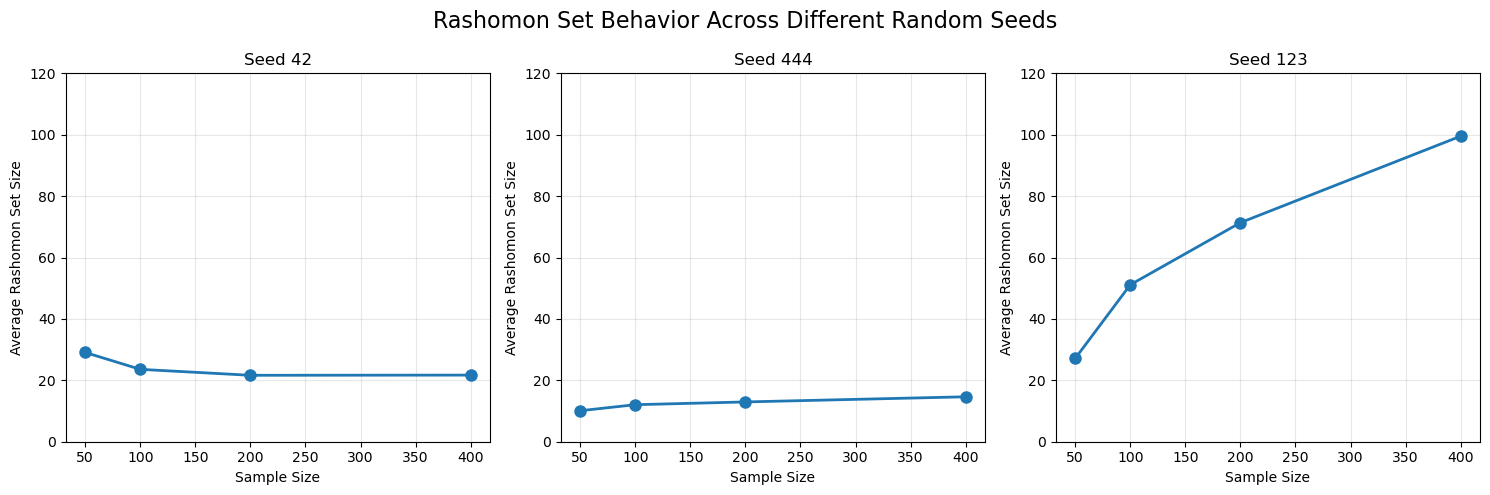

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def diagnose_seed_behavior(seeds=[42, 444, 123], 
                          n_total=10000,
                          n_features=20,
                          k=5,
                          noise_level=1.5,
                          correlation_strength=0.3):
    """
    Diagnose why different seeds give such different results.
    """
    
    results = {}
    
    for seed in seeds:
        print(f"\n{'='*60}")
        print(f"Analyzing seed {seed}")
        print(f"{'='*60}")
        
        np.random.seed(seed)
        
        # Generate data
        X = np.random.randn(n_total, n_features)
        
        # Add correlation
        for i in range(0, n_features, 4):
            end_i = min(i + 4, n_features)
            if end_i - i > 1:
                common = np.random.randn(n_total, 1)
                X[:, i:end_i] = (1 - correlation_strength) * X[:, i:end_i] + \
                               correlation_strength * common
        
        # Select true variables
        true_variables = np.sort(np.random.choice(n_features, k, replace=False))
        true_coefs = np.zeros(n_features)
        true_coefs[true_variables] = np.random.uniform(-1, 1, k)
        
        # Generate response
        signal = X @ true_coefs
        noise = noise_level * np.random.randn(n_total)
        y = signal + noise
        
        # Calculate key statistics
        signal_std = np.std(signal)
        noise_std = np.std(noise)
        snr = signal_std / noise_std
        
        print(f"True variables: {true_variables}")
        print(f"True coefficients: {true_coefs[true_variables]}")
        print(f"Signal std: {signal_std:.3f}")
        print(f"Noise std: {noise_std:.3f}")
        print(f"Signal-to-noise ratio: {snr:.3f}")
        
        # Check correlation structure
        corr_matrix = np.corrcoef(X.T)
        
        # Look at correlations between true and other variables
        max_corrs = []
        for true_var in true_variables:
            other_vars = [i for i in range(n_features) if i not in true_variables]
            max_corr = np.max(np.abs(corr_matrix[true_var, other_vars]))
            max_corrs.append(max_corr)
        
        print(f"Max correlation between true and other vars: {np.max(max_corrs):.3f}")
        
        # Check condition number (multicollinearity)
        all_combinations = list(combinations(range(n_features), k))
        true_model_index = all_combinations.index(tuple(true_variables))
        
        # Sample some data to check conditioning
        sample_indices = np.random.choice(n_total, 200, replace=False)
        X_sample = X[sample_indices]
        
        # Check condition numbers for different models
        cond_numbers = []
        for i, feature_combo in enumerate(all_combinations[:100]):  # Check first 100
            X_subset = X_sample[:, list(feature_combo)]
            cond = np.linalg.cond(X_subset.T @ X_subset)
            cond_numbers.append(cond)
        
        print(f"Median condition number: {np.median(cond_numbers):.1f}")
        print(f"Max condition number: {np.max(cond_numbers):.1f}")
        
        # Analyze spurious correlations
        spurious_corrs = []
        for i in range(n_features):
            if i not in true_variables:
                corr = np.corrcoef(X[:, i], y)[0, 1]
                spurious_corrs.append(abs(corr))
        
        print(f"Max spurious correlation with y: {np.max(spurious_corrs):.3f}")
        print(f"Mean spurious correlation with y: {np.mean(spurious_corrs):.3f}")
        
        # Store results
        results[seed] = {
            'true_vars': true_variables,
            'true_coefs': true_coefs[true_variables],
            'snr': snr,
            'max_cross_corr': np.max(max_corrs),
            'max_spurious_corr': np.max(spurious_corrs),
            'median_cond': np.median(cond_numbers)
        }
    
    return results

def test_fixed_dgp_bootstrap(n_total=10000,
                           n_features=20,
                           k=5,
                           noise_level=1.5,
                           correlation_strength=0.3,
                           n_bootstrap=100,
                           sample_sizes=[50, 100, 200, 400],
                           random_seed=42):
    """
    Test with a FIXED DGP and only bootstrap the sampling.
    This is what you originally wanted - same population, different samples.
    """
    
    print("Generating FIXED population...")
    np.random.seed(random_seed)
    
    # Generate data ONCE
    X = np.random.randn(n_total, n_features)
    
    # Add correlation
    for i in range(0, n_features, 4):
        end_i = min(i + 4, n_features)
        if end_i - i > 1:
            common = np.random.randn(n_total, 1)
            X[:, i:end_i] = 0.7 * X[:, i:end_i] + 0.3 * common
    
    # Fixed true model
    true_variables = np.sort(np.random.choice(n_features, k, replace=False))
    true_coefs = np.zeros(n_features)
    true_coefs[true_variables] = np.random.uniform(-1, 1, k)
    
    # Fixed population
    y = X @ true_coefs + noise_level * np.random.randn(n_total)
    
    print(f"True model (FIXED): {true_variables}")
    print(f"SNR (FIXED): {np.std(X @ true_coefs) / noise_level:.3f}")
    
    # Split into train and validation (FIXED)
    val_size = 2000
    np.random.seed(random_seed + 1000)  # Different seed for split
    val_indices = np.random.choice(n_total, val_size, replace=False)
    train_indices = np.setdiff1d(range(n_total), val_indices)
    
    X_val = X[val_indices]
    y_val = y[val_indices]
    
    # Pre-compute combinations
    all_combinations = list(combinations(range(n_features), k))
    
    results = []
    
    for sample_size in sample_sizes:
        print(f"\nBootstrapping sample size {sample_size}...")
        
        rashomon_sizes = []
        
        for boot in range(n_bootstrap):
            # Bootstrap from the FIXED training population
            np.random.seed(random_seed + 2000 + boot)  # Controlled bootstrap seeds
            train_sample = np.random.choice(train_indices, sample_size, replace=True)
            X_train = X[train_sample]
            y_train = y[train_sample]
            
            # Evaluate all models on FIXED validation set
            val_mse = []
            for feature_combo in all_combinations:
                X_subset_train = X_train[:, list(feature_combo)]
                X_subset_val = X_val[:, list(feature_combo)]
                
                try:
                    model = LinearRegression()
                    model.fit(X_subset_train, y_train)
                    y_pred_val = model.predict(X_subset_val)
                    mse = mean_squared_error(y_val, y_pred_val)
                except:
                    mse = float('inf')
                
                val_mse.append(mse)
            
            val_mse = np.array(val_mse)
            best_mse = np.min(val_mse)
            
            # Count models within 1% of best
            threshold_mse = best_mse * 1.01
            rashomon_size = np.sum(val_mse <= threshold_mse)
            rashomon_sizes.append(rashomon_size)
        
        avg_size = np.mean(rashomon_sizes)
        std_size = np.std(rashomon_sizes)
        results.append((sample_size, avg_size, std_size))
        print(f"  Average Rashomon set size: {avg_size:.1f} ± {std_size:.1f}")
    
    return results, true_variables

def compare_approaches():
    """
    Compare the two approaches:
    1. Different seeds = different DGPs
    2. Fixed DGP with bootstrap sampling
    """
    
    print("="*60)
    print("APPROACH 1: Different seeds (different DGPs)")
    print("="*60)
    
    # First diagnose why seeds differ
    diagnosis = diagnose_seed_behavior([42, 444, 123])
    
    print("\n" + "="*60)
    print("APPROACH 2: Fixed DGP with bootstrap")
    print("="*60)
    
    results_fixed, true_vars = test_fixed_dgp_bootstrap(
        n_bootstrap=100,
        sample_sizes=[50, 100, 200, 400],
        random_seed=42
    )
    
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print("\nDifferent seeds create different DGPs with:")
    print("- Different true variables")
    print("- Different signal-to-noise ratios")
    print("- Different correlation structures")
    print("- Different spurious correlations")
    print("\nThis explains the wildly different behaviors!")
    print("\nFor proper bootstrap analysis, use FIXED DGP approach.")
    
    return diagnosis, results_fixed

# Visualization function
def plot_seed_comparison(seeds=[42, 444, 123], n_iterations=50):
    """
    Visualize how different seeds behave differently.
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        
        # Generate data
        n_total = 10000
        n_features = 20
        k = 5
        
        X = np.random.randn(n_total, n_features)
        
        # Add correlation
        for i in range(0, n_features, 4):
            end_i = min(i + 4, n_features)
            if end_i - i > 1:
                common = np.random.randn(n_total, 1)
                X[:, i:end_i] = 0.7 * X[:, i:end_i] + 0.3 * common
        
        true_variables = np.sort(np.random.choice(n_features, k, replace=False))
        true_coefs = np.zeros(n_features)
        true_coefs[true_variables] = np.random.uniform(-1, 1, k)
        
        y = X @ true_coefs + 1.5 * np.random.randn(n_total)
        
        # Split data
        val_size = 2000
        val_indices = np.random.choice(n_total, val_size, replace=False)
        train_indices = np.setdiff1d(range(n_total), val_indices)
        
        X_val = X[val_indices]
        y_val = y[val_indices]
        
        # Test different sample sizes
        sample_sizes = [50, 100, 200, 400]
        all_combinations = list(combinations(range(n_features), k))
        
        avg_sizes = []
        
        for sample_size in sample_sizes:
            rashomon_sizes = []
            
            for _ in range(n_iterations):
                train_sample = np.random.choice(train_indices, sample_size, replace=False)
                X_train = X[train_sample]
                y_train = y[train_sample]
                
                val_mse = []
                for feature_combo in all_combinations:
                    X_subset_train = X_train[:, list(feature_combo)]
                    X_subset_val = X_val[:, list(feature_combo)]
                    
                    model = LinearRegression()
                    model.fit(X_subset_train, y_train)
                    y_pred_val = model.predict(X_subset_val)
                    mse = mean_squared_error(y_val, y_pred_val)
                    val_mse.append(mse)
                
                val_mse = np.array(val_mse)
                best_mse = np.min(val_mse)
                threshold_mse = best_mse * 1.01
                rashomon_size = np.sum(val_mse <= threshold_mse)
                rashomon_sizes.append(rashomon_size)
            
            avg_sizes.append(np.mean(rashomon_sizes))
        
        # Plot
        ax = axes[idx]
        ax.plot(sample_sizes, avg_sizes, 'o-', linewidth=2, markersize=8)
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Average Rashomon Set Size')
        ax.set_title(f'Seed {seed}')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, max(120, max(avg_sizes) * 1.1))
    
    plt.suptitle('Rashomon Set Behavior Across Different Random Seeds', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run comparison
    diagnosis, fixed_results = compare_approaches()
    
    # Visualize
    plot_seed_comparison()

## Ellipsoid Intuition

In [20]:
import numpy as np
import pandas as pd
from itertools import combinations
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')

print(f"Using threading for Jupyter notebook compatibility")

# EXTREME multiplicity: Make variables nearly identical
np.random.seed(42)
P_TOTAL = 30        
P_TRUE = 25         # Almost all variables are useful
P_SELECT = 5        
SIGMA = 8.0         # VERY high noise - signal-to-noise ratio ~1:4
SAMPLE_SIZES = [50, 100, 200, 500, 1000]  # Very small samples
N_REPLICATIONS = 3   
EPSILON_VALUES = [0.01, 0.03, 0.05]  # Extended range

# CRITICAL: Make coefficients nearly identical with tiny random variation
TRUE_BETA = np.zeros(P_TOTAL)

# Make first 25 variables have almost identical effects
np.random.seed(456)
TRUE_BETA[:25] = 1.0 + np.random.normal(0, 0.05, 25)  # Mean=1.0, very small variation

# Last 5 variables are truly noise
TRUE_BETA[25:] = np.random.normal(0, 0.1, 5)

print(f"Creating EXTREME substitutability:")
print(f"Variables 0-24: {TRUE_BETA[:25].round(3)}")
print(f"Variables 25-29: {TRUE_BETA[25:].round(3)}")
print(f"Coefficient range for useful vars: {TRUE_BETA[:25].min():.3f} to {TRUE_BETA[:25].max():.3f}")
print(f"Standard deviation of useful coefficients: {TRUE_BETA[:25].std():.4f}")

class RashomonSimulator:
    """Enhanced simulator designed for high model multiplicity"""
    
    def __init__(self):
        self.results_cache = {}
    
    def generate_correlated_X(self, n, p):
        """Generate extremely correlated predictor matrix - variables are nearly identical"""
        # Make first 25 variables almost perfectly correlated
        Sigma = np.eye(p)
        
        # EXTREME correlation among useful variables (0-24)
        for i in range(25):
            for j in range(25):
                if i != j:
                    Sigma[i, j] = 0.95  # Nearly perfect correlation
        
        # Noise variables (25-29) are independent
        for i in range(25, p):
            for j in range(25):
                Sigma[i, j] = Sigma[j, i] = 0.1  # Low correlation with useful vars
        
        return np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

    def generate_data(self, n, p_total, true_beta, sigma):
        """Generate synthetic dataset with extreme substitutability"""
        X = self.generate_correlated_X(n, p_total)
        
        # Linear model with high noise - no interactions to keep it simple
        y = X @ true_beta 
        
        # Add very high noise to create lots of uncertainty
        y += np.random.normal(0, sigma, n)
        
        return X, y

    def fit_subset_model(self, X, y, subset_indices):
        """Fit linear regression on subset of variables and return RSS"""
        X_sub = X[:, subset_indices]
        
        try:
            model = LinearRegression(fit_intercept=True)
            model.fit(X_sub, y)
            y_pred = model.predict(X_sub)
            rss = np.sum((y - y_pred) ** 2)
            
            # Also return R-squared for diagnostics
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r2 = 1 - (rss / ss_tot)
            
            return {
                'rss': rss, 
                'subset': subset_indices, 
                'r2': r2,
                'model': model
            }
        except:
            return {
                'rss': np.inf, 
                'subset': subset_indices, 
                'r2': -np.inf,
                'model': None
            }

    def evaluate_subset_batch(self, args):
        """Evaluate a batch of subsets - for threading"""
        X, y, subset_batch = args
        results = []
        for subset in subset_batch:
            result = self.fit_subset_model(X, y, subset)
            results.append(result)
        return results

    def evaluate_all_subsets_threaded(self, X, y, p_select, max_workers=None):
        """Evaluate all possible p_select-variable subsets using threading"""
        all_subsets = list(combinations(range(X.shape[1]), p_select))
        n_subsets = len(all_subsets)
        
        print(f"Evaluating {n_subsets:,} subsets...")
        
        # Split subsets into batches for threading
        batch_size = max(1, n_subsets // (max_workers or 8))
        subset_batches = [all_subsets[i:i+batch_size] for i in range(0, n_subsets, batch_size)]
        
        # Prepare arguments for threading
        args_list = [(X, y, batch) for batch in subset_batches]
        
        all_results = []
        
        # Use ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_batch = {
                executor.submit(self.evaluate_subset_batch, args): args[2] 
                for args in args_list
            }
            
            for future in tqdm(as_completed(future_to_batch), 
                              total=len(future_to_batch), 
                              desc="Processing batches"):
                try:
                    batch_results = future.result()
                    all_results.extend(batch_results)
                except Exception as exc:
                    print(f'Batch generated an exception: {exc}')
        
        return all_results

    def count_rashomon_models(self, results, epsilon_values):
        """Count models within epsilon of the best model"""
        # Filter out infinite RSS values
        valid_results = [r for r in results if r['rss'] != np.inf]
        
        if not valid_results:
            return {f'epsilon_{eps}': 0 for eps in epsilon_values}, np.inf, pd.DataFrame()
        
        # Sort by RSS
        results_df = pd.DataFrame(valid_results)
        results_df = results_df.sort_values('rss').reset_index(drop=True)
        
        min_rss = results_df['rss'].min()
        max_r2 = results_df['r2'].max()
        
        print(f"    Min RSS: {min_rss:.3f}, Max R²: {max_r2:.3f}")
        
        # Show RSS distribution
        percentiles = [1, 5, 10, 25]
        for p in percentiles:
            rss_p = results_df['rss'].quantile(p/100)
            pct_increase = (rss_p - min_rss) / min_rss * 100
            print(f"    {p}th percentile RSS: {rss_p:.3f} (+{pct_increase:.1f}% from min)")
        
        rashomon_counts = {}
        for epsilon in epsilon_values:
            threshold = min_rss * (1 + epsilon)
            count = (results_df['rss'] <= threshold).sum()
            rashomon_counts[f'epsilon_{epsilon}'] = count
            pct_of_total = count / len(results_df) * 100
            print(f"    Models within {epsilon*100:>4.1f}% of best: {count:>5} ({pct_of_total:4.1f}% of all models)")
        
        return rashomon_counts, min_rss, results_df

    def show_top_models(self, results_df, n_models=5):
        """Show the top models for interpretation"""
        top_models = results_df.head(n_models)
        print(f"\nTop {n_models} Models:")
        print("-" * 60)
        for i, row in top_models.iterrows():
            subset = row['subset']
            rss = row['rss']
            r2 = row['r2']
            pct_worse = (rss - results_df['rss'].min()) / results_df['rss'].min() * 100
            
            # Group variables by their original groups
            group_counts = {}
            for var in subset:
                group = var // 5
                group_counts[group] = group_counts.get(group, 0) + 1
            
            group_str = ", ".join([f"Group{g}:{c}" for g, c in sorted(group_counts.items())])
            
            print(f"Model {i+1}: Variables {subset}")
            print(f"         RSS: {rss:.3f} (+{pct_worse:.2f}%), R²: {r2:.3f}")
            print(f"         Variable groups: {group_str}")
            print()

    def run_single_simulation(self, sample_size, rep):
        """Run a single simulation for given sample size and replication"""
        print(f"  Running replication {rep+1} for sample size {sample_size}")
        
        # Generate data with specific random seed for this replication
        np.random.seed(42 + rep * 100 + sample_size)
        X, y = self.generate_data(sample_size, P_TOTAL, TRUE_BETA, SIGMA)
        
        # Print some diagnostics
        print(f"    Data shape: X={X.shape}, y={y.shape}")
        print(f"    y variance: {np.var(y):.3f}, y mean: {np.mean(y):.3f}")
        
        # Evaluate all subsets
        results = self.evaluate_all_subsets_threaded(X, y, P_SELECT, max_workers=4)
        
        # Count Rashomon models
        rashomon_counts, min_rss, results_df = self.count_rashomon_models(results, EPSILON_VALUES)
        
        # Show top models for the first replication of smallest sample size
        if sample_size == SAMPLE_SIZES[0] and rep == 0:
            self.show_top_models(results_df, n_models=10)
        
        return {
            'sample_size': sample_size,
            'replication': rep,
            'min_rss': min_rss,
            'max_r2': results_df['r2'].max() if len(results_df) > 0 else 0,
            'n_valid_models': len([r for r in results if r['rss'] != np.inf]),
            **rashomon_counts
        }

    def run_simulation_study(self):
        """Run the complete simulation study"""
        print("Starting Enhanced Rashomon Set Simulation Study")
        print(f"Total combinations of {P_SELECT} from {P_TOTAL}: {len(list(combinations(range(P_TOTAL), P_SELECT))):,}")
        print(f"True coefficients by groups:")
        print(f"  High-effect vars (0-19):  {TRUE_BETA[0:10].round(2)} ...")
        print(f"  Lower-effect vars (20-29): {TRUE_BETA[20:].round(2)}")
        print(f"  Mean effect sizes: Group1={TRUE_BETA[:20].mean():.2f}, Group2={TRUE_BETA[20:].mean():.2f}")
        
        all_results = []
        
        for sample_size in SAMPLE_SIZES:
            print(f"\nRunning simulations for sample size {sample_size}")
            
            for rep in range(N_REPLICATIONS):
                try:
                    result = self.run_single_simulation(sample_size, rep)
                    all_results.append(result)
                except Exception as exc:
                    print(f'Simulation (n={sample_size}, rep={rep}) failed: {exc}')
        
        return pd.DataFrame(all_results)

    def analyze_results(self, results_df):
        """Analyze and visualize simulation results"""
        print("\n" + "="*70)
        print("SIMULATION RESULTS")
        print("="*70)
        
        # Summary statistics
        summary_cols = ['epsilon_0.01', 'epsilon_0.05', 'epsilon_0.1', 'epsilon_0.2', 'min_rss', 'max_r2']
        summary = results_df.groupby('sample_size')[summary_cols].agg(['mean', 'std']).round(2)
        
        print("\nSummary Statistics:")
        print(summary)
        
        # Calculate scaling relationships for different epsilons
        for eps in [0.01, 0.05, 0.10]:
            print(f"\nRashomon Set Size Scaling (epsilon = {eps*100}%):")
            for i, n in enumerate(SAMPLE_SIZES[:-1]):
                n_next = SAMPLE_SIZES[i+1]
                count_n = results_df[results_df['sample_size'] == n][f'epsilon_{eps}'].mean()
                count_n_next = results_df[results_df['sample_size'] == n_next][f'epsilon_{eps}'].mean()
                if count_n_next > 0:
                    ratio = count_n / count_n_next
                    theoretical_ratio = (n_next / n) ** (P_SELECT / 2)
                    print(f"  n={n} to n={n_next}: Observed ratio = {ratio:.2f}, "
                          f"Theoretical n^(-p/2) ratio = {theoretical_ratio:.2f}")
        
        # Create enhanced visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Rashomon set size vs sample size (linear scale)
        ax1 = axes[0, 0]
        for epsilon in EPSILON_VALUES:
            col = f'epsilon_{epsilon}'
            if col in results_df.columns:
                mean_counts = results_df.groupby('sample_size')[col].mean()
                std_counts = results_df.groupby('sample_size')[col].std()
                
                ax1.errorbar(SAMPLE_SIZES, mean_counts, yerr=std_counts, 
                            marker='o', label=f'ε = {epsilon*100}%', capsize=5)
        
        ax1.set_xlabel('Sample Size')
        ax1.set_ylabel('Number of Models in Rashomon Set')
        ax1.set_title('Rashomon Set Size vs Sample Size (Linear)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Log-log plot 
        ax2 = axes[0, 1]
        for eps in [0.01, 0.05, 0.10]:
            col = f'epsilon_{eps}'
            mean_counts = results_df.groupby('sample_size')[col].mean()
            
            if mean_counts.max() > 1:
                ax2.loglog(SAMPLE_SIZES, mean_counts, 'o-', 
                          label=f'ε = {eps*100}%', markersize=6)
        
        # Theoretical line
        if results_df['epsilon_0.05'].max() > 1:
            base_count = results_df[results_df['sample_size'] == SAMPLE_SIZES[0]]['epsilon_0.05'].mean()
            theoretical = (SAMPLE_SIZES[0] / np.array(SAMPLE_SIZES)) ** (P_SELECT / 2) * base_count
            ax2.loglog(SAMPLE_SIZES, theoretical, 'k--', label='Theoretical n^(-p/2)', alpha=0.7)
        
        ax2.set_xlabel('Sample Size (log)')
        ax2.set_ylabel('Rashomon Set Size (log)')
        ax2.set_title('Log-Log: Scaling Relationship')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: R-squared vs sample size
        ax3 = axes[0, 2]
        mean_r2 = results_df.groupby('sample_size')['max_r2'].mean()
        std_r2 = results_df.groupby('sample_size')['max_r2'].std()
        
        ax3.errorbar(SAMPLE_SIZES, mean_r2, yerr=std_r2, 
                    marker='o', capsize=5, color='green')
        ax3.set_xlabel('Sample Size')
        ax3.set_ylabel('Maximum R²')
        ax3.set_title('Best Model R² vs Sample Size')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Distribution of model counts
        ax4 = axes[1, 0]
        
        eps_to_plot = 0.05
        col = f'epsilon_{eps_to_plot}'
        if col in results_df.columns:
            for size in SAMPLE_SIZES:
                data = results_df[results_df['sample_size'] == size][col]
                ax4.hist(data, bins=max(3, len(data)//2), alpha=0.6, 
                        label=f'n={size}', density=True)
        
        ax4.set_xlabel(f'Rashomon Set Size (ε = {eps_to_plot*100}%)')
        ax4.set_ylabel('Density')
        ax4.set_title('Distribution of Rashomon Set Sizes')
        ax4.legend()
        
        # Plot 5: Percentage of models in Rashomon set
        ax5 = axes[1, 1]
        total_models = len(list(combinations(range(P_TOTAL), P_SELECT)))
        
        for epsilon in EPSILON_VALUES[:3]:  # First 3 epsilons
            col = f'epsilon_{epsilon}'
            mean_pct = results_df.groupby('sample_size')[col].mean() / total_models * 100
            
            ax5.plot(SAMPLE_SIZES, mean_pct, 'o-', label=f'ε = {epsilon*100}%')
        
        ax5.set_xlabel('Sample Size')
        ax5.set_ylabel('% of All Models in Rashomon Set')
        ax5.set_title('Percentage of Models in Rashomon Set')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # Plot 6: Min RSS vs sample size
        ax6 = axes[1, 2]
        mean_rss = results_df.groupby('sample_size')['min_rss'].mean()
        std_rss = results_df.groupby('sample_size')['min_rss'].std()
        
        ax6.errorbar(SAMPLE_SIZES, mean_rss, yerr=std_rss, 
                    marker='o', capsize=5, color='red')
        ax6.set_xlabel('Sample Size')
        ax6.set_ylabel('Minimum RSS')
        ax6.set_title('Best Model RSS vs Sample Size')
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return summary



Using threading for Jupyter notebook compatibility
Creating EXTREME substitutability:
Variables 0-24: [0.967 0.975 1.031 1.028 1.068 1.081 1.015 1.022 0.983 0.984 0.899 0.943
 0.944 1.012 0.984 1.097 1.096 1.046 1.047 1.058 0.995 0.996 0.951 0.981
 1.057]
Variables 25-29: [ 0.014 -0.037 -0.03   0.011  0.114]
Coefficient range for useful vars: 0.899 to 1.097
Standard deviation of useful coefficients: 0.0500


In [21]:
# ENHANCED DIAGNOSTIC TEST
print("="*70)
print("ENHANCED DIAGNOSTIC TEST")
print("="*70)

simulator = RashomonSimulator()
X_test, y_test = simulator.generate_data(100, P_TOTAL, TRUE_BETA, SIGMA)

print(f"Test data generated:")
print(f"X shape: {X_test.shape}")
print(f"y stats: mean={np.mean(y_test):.3f}, std={np.std(y_test):.3f}")
print(f"True beta summary:")
print(f"  Variables 0-24 (nearly identical): mean={TRUE_BETA[:25].mean():.3f}, std={TRUE_BETA[:25].std():.4f}")
print(f"  Variables 25-29 (noise): mean={TRUE_BETA[25:].mean():.3f}, std={TRUE_BETA[25:].std():.3f}")
print(f"  Signal-to-noise ratio: ~{TRUE_BETA[:25].mean()/SIGMA:.2f}")

# Test with strategic subsets - all from the nearly-identical variables
np.random.seed(42)
test_subsets = []

# Strategy 1: Many combinations of 5 from the first 25 (nearly identical) variables
for _ in range(30):
    subset = tuple(sorted(np.random.choice(25, 5, replace=False)))
    test_subsets.append(subset)

# Strategy 2: Mix of good and noise variables
for _ in range(5):
    good_vars = np.random.choice(25, 4, replace=False)  # 4 good
    noise_vars = np.random.choice(range(25, 30), 1, replace=False)  # 1 noise
    subset = tuple(sorted(list(good_vars) + list(noise_vars)))
    test_subsets.append(subset)

# Remove duplicates
test_subsets = list(set(test_subsets))

test_results = []
for subset in test_subsets:
    result = simulator.fit_subset_model(X_test, y_test, subset)
    test_results.append(result)

# Sort by RSS and show results
test_results.sort(key=lambda x: x['rss'])

print(f"\nTop 10 models from {len(test_results)} tested:")
for i, result in enumerate(test_results[:10]):
    subset = result['subset']
    rss = result['rss']
    r2 = result['r2']
    
    # Show which groups variables come from
    groups = [f"G{var//5}" for var in subset]
    print(f"{i+1:2}. Variables {subset}: RSS={rss:.1f}, R²={r2:.3f}, Groups={groups}")

min_test_rss = test_results[0]['rss']
print(f"\nRashomon set analysis:")
for eps in [0.01, 0.05, 0.10, 0.20]:
    count = sum(1 for r in test_results if r['rss'] <= min_test_rss * (1 + eps))
    pct = count / len(test_results) * 100
    print(f"  Within {eps*100:>4.1f}% of best: {count:>2}/{len(test_results)} ({pct:4.1f}%)")



ENHANCED DIAGNOSTIC TEST
Test data generated:
X shape: (100, 30)
y stats: mean=2.034, std=24.648
True beta summary:
  Variables 0-24 (nearly identical): mean=1.010, std=0.0500
  Variables 25-29 (noise): mean=0.014, std=0.054
  Signal-to-noise ratio: ~0.13

Top 10 models from 35 tested:
 1. Variables (0, 7, 16, 17, 22): RSS=6292.4, R²=0.896, Groups=['G0', 'G1', 'G3', 'G3', 'G4']
 2. Variables (3, 5, 8, 17, 22): RSS=6329.0, R²=0.896, Groups=['G0', 'G1', 'G1', 'G3', 'G4']
 3. Variables (5, 9, 13, 18, 20): RSS=6494.3, R²=0.893, Groups=['G1', 'G1', 'G2', 'G3', 'G4']
 4. Variables (3, 9, 13, 16, 22): RSS=6557.2, R²=0.892, Groups=['G0', 'G1', 'G2', 'G3', 'G4']
 5. Variables (5, 8, 10, 15, 16): RSS=6643.7, R²=0.891, Groups=['G1', 'G1', 'G2', 'G3', 'G3']
 6. Variables (9, 14, 19, 21, 22): RSS=6681.8, R²=0.890, Groups=['G1', 'G2', 'G3', 'G4', 'G4']
 7. Variables (5, 16, 20, 23, 24): RSS=6694.5, R²=0.890, Groups=['G1', 'G3', 'G4', 'G4', 'G4']
 8. Variables (0, 7, 8, 17, 24): RSS=6730.1, R²=0.889,

In [23]:
print("\n" + "="*70)
print("RUNNING FULL ENHANCED SIMULATION")
print("="*70)

# Run the full simulation
results_df = simulator.run_simulation_study()
summary = simulator.analyze_results(results_df)

print(f"\nSimulation completed!")
print(f"Results stored in 'results_df' DataFrame with {len(results_df)} rows")


RUNNING FULL ENHANCED SIMULATION
Starting Enhanced Rashomon Set Simulation Study
Total combinations of 5 from 30: 142,506
True coefficients by groups:
  High-effect vars (0-19):  [0.97 0.98 1.03 1.03 1.07 1.08 1.02 1.02 0.98 0.98] ...
  Lower-effect vars (20-29): [ 0.99  1.    0.95  0.98  1.06  0.01 -0.04 -0.03  0.01  0.11]
  Mean effect sizes: Group1=1.01, Group2=0.51

Running simulations for sample size 50
  Running replication 1 for sample size 50
    Data shape: X=(50, 30), y=(50,)
    y variance: 741.700, y mean: -0.790
Evaluating 142,506 subsets...


Processing batches:   0%|                                 | 0/5 [00:02<?, ?it/s]

KeyboardInterrupt

